# HW5: Dyna-Q

> - Full Name: **Payam Taebi**
> - Student ID: **400104867**


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_Dyna.ipynb)

## Overview
Here the goal is to implement **Dyna-Q** for [gymnasium environments](https://gymnasium.farama.org/).
More specificly we focus on the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment and try to solve its variants (different map sizes, slippery/non-slippery, etc).

No matter which setting you choose the plotting functions and algorithms don't need any alteration!



In [1]:
# @title Imports

# Stuff you (might) need
import random
import numpy as np
import gymnasium as gym
from tqdm.notebook import trange
from heapq import heappush, heappop
from collections import defaultdict

# Stuff used for visualization
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

import base64
import imageio
import IPython

import seaborn as sns

In [2]:
# @title Visualization Functions

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=env.metadata['render_fps']) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                action = policy(state, Q)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_rewards(rewards, average_range=None, ax=None, show=False):
    if ax is None:
        fig, ax = plt.subplots()
    xs = range(1, len(rewards) + 1)
    ax.plot(xs, rewards, marker='o', linestyle='--', label='Episode Reward')
    ax.plot(xs, np.cumsum(rewards) / xs, marker='x', label='Cumulative Average')
    ax.legend()
    ax.set(xlabel='Episodes', ylabel='Total Reward', title='Episode Rewards')
    if show:
        plt.show()


def plot_heatmap(env, value, color_terminal_states=True, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        fig, ax = plt.subplots()
    dim_x, dim_y = env.unwrapped.desc.shape
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    for i in range(dim_x * dim_y):
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
            labels[i] = 'H'
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
            labels[i] = 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="RdYlGn", annot=labels, annot_kws={'fontsize': 16}, fmt='s')

    if color_terminal_states:
        for i in range(dim_x * dim_y):
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='black'))
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='purple'))

    ax.set(title='Maximum Value per State')
    ax.set_xticks(np.linspace(0.5, dim_x-0.5, num=dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(dim_x)])
    ax.set_yticks(np.linspace(0.5, dim_y-0.5, num=dim_y))
    ax.set_yticklabels(["%d" % y for y in np.arange(dim_y)], rotation='horizontal')
    if show:
        plt.show()
    return im


def get_color_for_value(value, vmin, vmax):
    # Normalize the value between 0 and 1
    norm_value = (value - vmin) / (vmax - vmin)
    # Get color from a colormap
    colormap = plt.cm.RdYlGn  # You can choose any other colormap
    return colormap(norm_value)


def plot_q_values_grid(q_values, env, square_size=1, color_terminal_states=True, ax=None, show=False):
    grid = env.unwrapped.desc
    rows, cols = grid.shape
    q_values = q_values.reshape(rows, cols, 4)

    if ax is None:
      fig, ax = plt.subplots()

    # Determine the range of Q-values for normalization
    vmin = np.min(q_values)
    vmax = np.max(q_values)

    # Actions correspond to directions: 0=left, 1=right, 2=down, 3=up
    actions = {0: 'left', 2: 'right', 3: 'down', 1: 'up'}

    # Loop through each position in the grid
    for i in range(rows):
        for j in range(cols):
            # Calculate the lower-left corner of the square
            x = j * square_size
            y = i * square_size

            # Define the corners of the square
            bl = (x, y)  # bottom-left
            br = (x + square_size, y)  # bottom-right
            tl = (x, y + square_size)  # top-left
            tr = (x + square_size, y + square_size)  # top-right

            # Get Q-values for current state (i, j)
            q_left = q_values[i, j, 0]
            q_up = q_values[i, j, 1]
            q_right = q_values[i, j, 2]
            q_down = q_values[i, j, 3]

            # Check if the current cell is the one to be colored black
            if color_terminal_states and grid[i, j] == b'H':
                edge_color = None
                left_color, right_color, down_color, up_color = ['black'] * 4
            elif color_terminal_states and grid[i, j] == b'G':
                edge_color = None
                left_color, right_color, down_color, up_color = ['purple'] * 4
            else:
                edge_color = 'black'
                left_color = get_color_for_value(q_left, vmin, vmax)
                right_color = get_color_for_value(q_right, vmin, vmax)
                down_color = get_color_for_value(q_down, vmin, vmax)
                up_color = get_color_for_value(q_up, vmin, vmax)

            # Draw and color the triangles based on Q-values
            triangle_left = patches.Polygon([bl, tl, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=left_color)
            triangle_right = patches.Polygon([br, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                             edgecolor=edge_color, facecolor=right_color)
            triangle_down = patches.Polygon([bl, br, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=down_color)
            triangle_up = patches.Polygon([tl, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                          edgecolor=edge_color, facecolor=up_color)

            ax.add_patch(triangle_left)
            ax.add_patch(triangle_right)
            ax.add_patch(triangle_down)
            ax.add_patch(triangle_up)

    # Set the title
    ax.set(title='Action-State Values')

    # Set the limits of the plot
    ax.set_xlim(0, cols * square_size)
    ax.set_ylim(0, rows * square_size)

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Disable ticks on both axes
    ax.set_xticks([])  # Disable x ticks
    ax.set_yticks([])  # Disable y ticks

    ax.invert_yaxis()  # Optional: Invert y-axis to have (0,0) at the top-left corner
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='RdYlGn'), ax=ax, label='Q-value')
    if show:
        plt.show()


def plot_performance(env, value, reward_sums):
    # Create a figure
    fig = plt.figure(figsize=(16, 12), dpi=200)

    # Define a GridSpec with 2 rows and 2 columns
    gs = GridSpec(2, 2, figure=fig)

    # Plot in the first row spanning both columns
    ax1 = fig.add_subplot(gs[0, :])
    plot_rewards(reward_sums, ax=ax1)

    # Plot in the second row
    ax2 = fig.add_subplot(gs[1, 0])
    plot_q_values_grid(value, env, ax=ax2)

    ax3 = fig.add_subplot(gs[1, 1])
    plot_heatmap(env, value, ax=ax3)

    # Show the plots
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Explore the Environment (5 points)

First we must create the environment.
In order to be able to render the environment we use `render_mode="rgb_array"` as the render mode.


In [3]:
slippery = True
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=slippery)

# Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Discrete(16)
Actions: Discrete(4)


Define a random policy that randomly selects an action from the action space.

In [4]:
def random_policy(*args):
    # Select a random action from the action space
    action = env.action_space.sample()
    return action

Visualize the random policy.

In [5]:
create_policy_eval_video(env, random_policy, 'random_policy', num_episodes=5)

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# Policies (5 points)

First define a greedy policy that takes a state $s$ and returns the action $a$ with the highest $Q(s,a)$.

In [6]:
def greedy_policy(state: int, q_values: np.ndarray) -> int:
    # Select the greedy action based on Q-values for the given state
    action = np.argmax(q_values[state])
    return action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now define a policy that selects a greedy action with probability $1-\varepsilon$ and selects a random action with probability $\varepsilon$, for given a constant $\varepsilon$.

In [7]:
def epsilon_greedy_policy(state: int, q_values: np.ndarray, epsilon: float) -> int:
    # With probability epsilon, select a random action
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        # Otherwise, select the greedy action based on Q-values for the given state
        action = np.argmax(q_values[state])
    return action

# Dyna-Q (25 points)

**Dyna-Q** combines model-free and model-based reinforcement learning by integrating direct learning from experience with planning from a learned model.
Unlike **Q-learning**, which only updates the action values based on real experiences, **Dyna-Q** uses a learned model of the environment to simulate additional experiences and update the action values, accelerating the learning process.

The environment we are working with is *deterministic* when `is_slippery=False`.
For this reason we use also use a *deterministic* model for the environment.
In order to see how **Dyna-Q** gets implemented for *stochastic* environmnets, check out the workshop!

## Planning (10 points)

In addition to this update from real experiences, **Dyna-Q** updates the action values using simulated experiences:


$$Q(s, a) \leftarrow Q(s, a) + \alpha \left(\hat{r} + \gamma \max_{a'} Q(\hat{s}, a') - Q(s, a)\right)$$


Complete the `q_planning` function to perform `n` steps of planning.

In [8]:
def q_planning(model: dict, q: np.ndarray, alpha: float, gamma: float, n: int) -> np.ndarray:
    # Perform n steps of planning
    for _ in range(n):
        # Randomly sample a known state-action pair from the model
        state, action = random.choice(list(model.keys()))
        # Get the predicted reward and next_state from the model
        reward, next_state = model[(state, action)]
        # Update the Q-value using the deterministic transition:
        # Q(s, a) <- Q(s, a) + alpha * (reward + gamma * max_a' Q(next_state, a') - Q(s, a))
        q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])
    return q

## Learning (15 points)

For `n_episodes`, take ɛ-greedy actions based on the Q-values and at each step update them:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)\right)$$

After each step you must also update the *deterministic* model and call `q_planning` to perform the planning steps.

In [9]:
def dyna_q(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
           gamma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Dyna-Q algorithm for deterministic environments."""

    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Dyna-Q model for deterministic environments:
    # a dictionary mapping (state, action) pairs to (reward, next_state)
    model = {}

    for episode_i in (pbar := trange(n_episodes, leave=False)):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # Take ɛ-greedy action based on Q-values
            action = epsilon_greedy_policy(state, q, epsilon)

            # Take a step in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update:
            q[state, action] = q[state, action] + alpha * (
                reward + gamma * np.max(q[next_state]) - q[state, action]
            )

            # Update the deterministic model with the observed transition
            model[(state, action)] = (reward, next_state)

            # Planning step: perform n simulated updates from the model
            q = q_planning(model, q, alpha, gamma, n)

            # Move to the next state
            state = next_state

            # Accumulate reward
            reward_sum += reward

        pbar.set_description(f'Episode Reward {int(reward_sum)}')
        reward_sums[episode_i] = reward_sum

    return q, reward_sums


# Experiments (15 points)

Here you can run a bunch of experiments.
You can use the given template for your experiments.

If you have trouble getting started, work with a smaller map instead by setting `map_name="4x4"` but keep in mind the ultimate goal of this assignment is solving the larger `8x8` grid.
Using a simpler environment could help you better understand the limitations and motivate you to come up with solutions.

After playing with the hyperparameters you should answer the following questions:

*   How does increasing the number of planning steps affect the overall learning process?
*   What would happen if we set `is_slippery=True` assuming we **didn't** change the *deterministic* nature of our algorithm?
*   Does planning even help for this specific environment? How so? (Hint: analyze the reward signal)
*   Assuming it takes $N_1$ episodes to reach the goal for the first time, and from then it takes $N_2$ episodes to reach the goal for the second time, explain how the number of planning steps `n` affects $N_1$ and $N_2$.

`Your Answers:` IN REPORT PDF



  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-2-98724c2daf64>:79: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - vmin) / (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


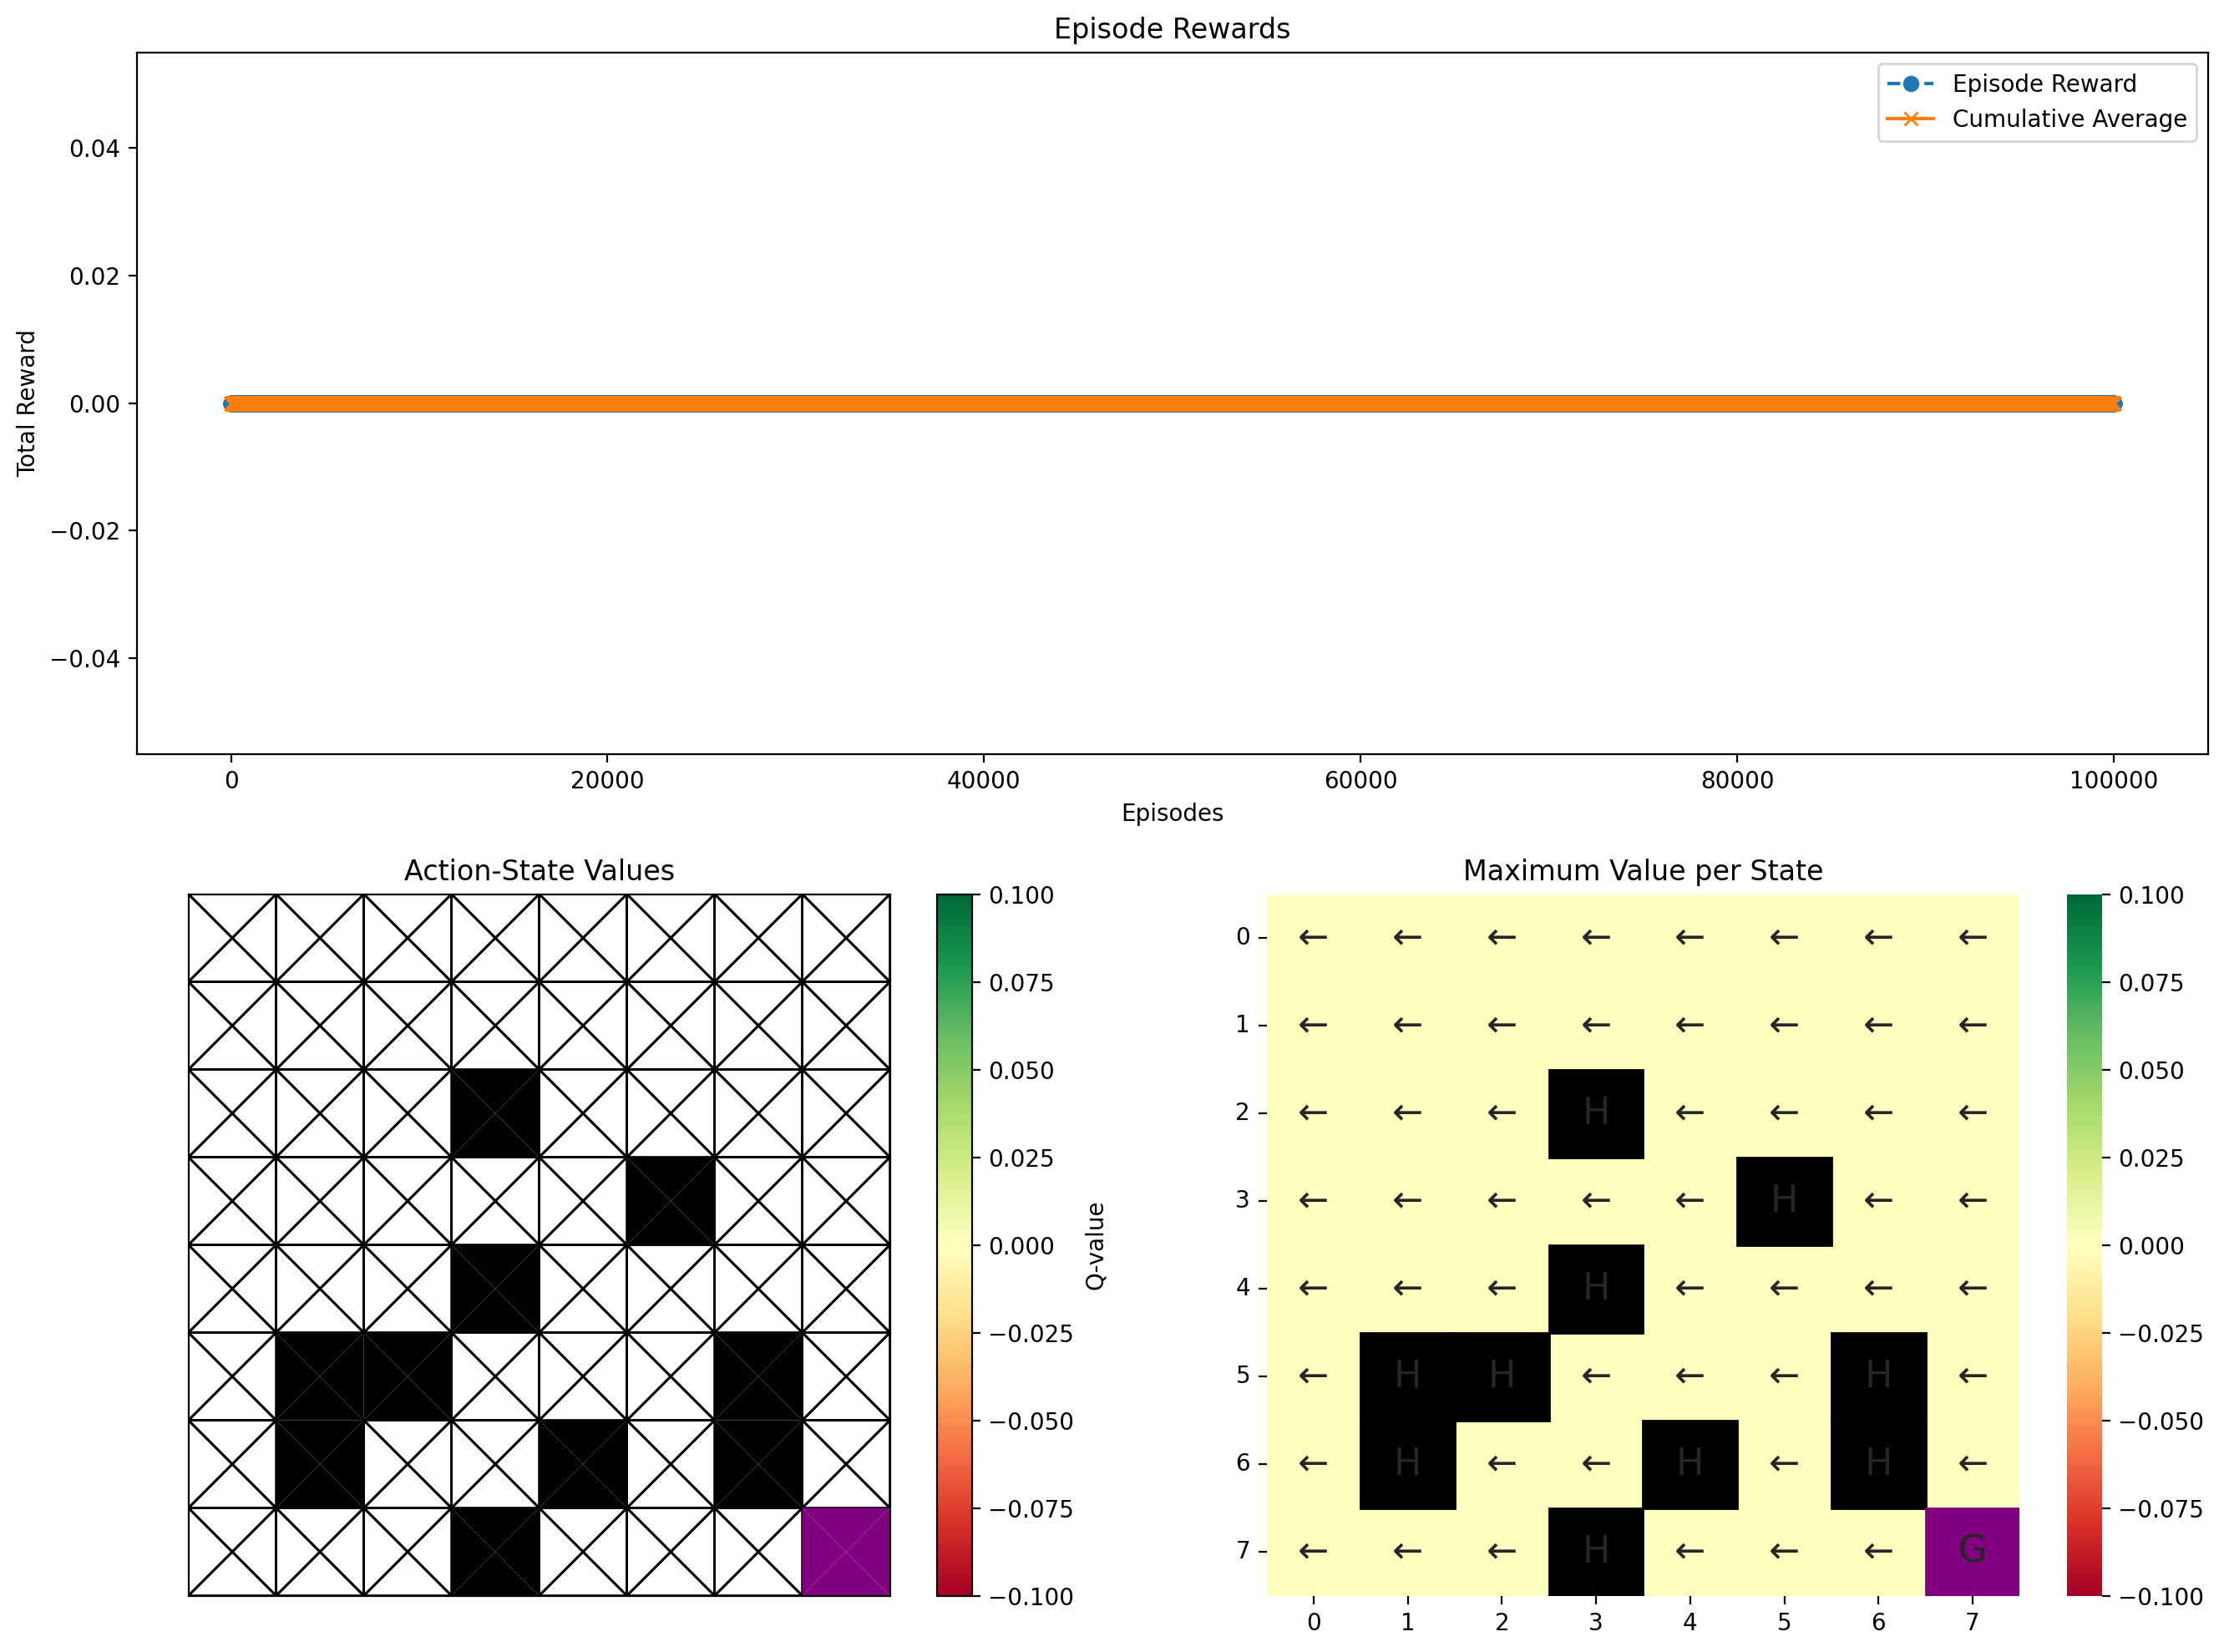

In [10]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'epsilon': 0.1,    # probability for random action (10% exploration)
          'alpha': 0.1,      # learning rate
          'gamma': 0.99,     # temporal discount factor
          'n': 50,           # number of planning steps per real step
}

# episodes/trials
n_episodes = 100000

# environment initialization using an 8x8 grid with non-slippery conditions
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

# Solve Frozen Lake using Dyna-Q
value_dyna_q, reward_sums_dyna_q = dyna_q(n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)

# Are you having troubles? (15 points)




Here are a number of options you can explore to see better results:

1.   Introduce a baseline for Q-values to speed up convergence during initialization.
2.   Change the value of $\varepsilon$ as a function of episode progression (or something else) for better exploration strategies.
3.   Replace the $\varepsilon$-greedy policy with a different policy that is better suited for this environment.
4.   Change the number of planning steps as a function of episode progression (or something else) for more efficient planning.

In the last two sections of this assignment, we examine how **Reward Shaping** and **Prioritized Sweeping** can yield better results.
Other than these two methods, you are more than welcome to introduce any other method to improve your results.

You can choose any or none of these methods at your discretion.
The only important detail is to be able to solve the environments.
You **MUST** justify each method and how it helps with issues you were facing before.

`Your Answer:`

### Experiment 1: Optimistic Initialization

**Modification:**  
Instead of initializing all Q-values to zero, we initialize them with an optimistic value (e.g., 1.0).

**Rationale:**  
Optimistic initialization makes all actions appear promising at the start. This encourages the agent to explore actions that have not been tried yet, which can lead to earlier discovery of rewarding states and faster convergence of Q-values.

**Observations:**  
With this modification, you should observe that:
- The Q-values begin to update sooner.
- The agent discovers the goal more effectively.
- Overall performance improves compared to using zero initialization.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100000 [00:00<?, ?it/s]

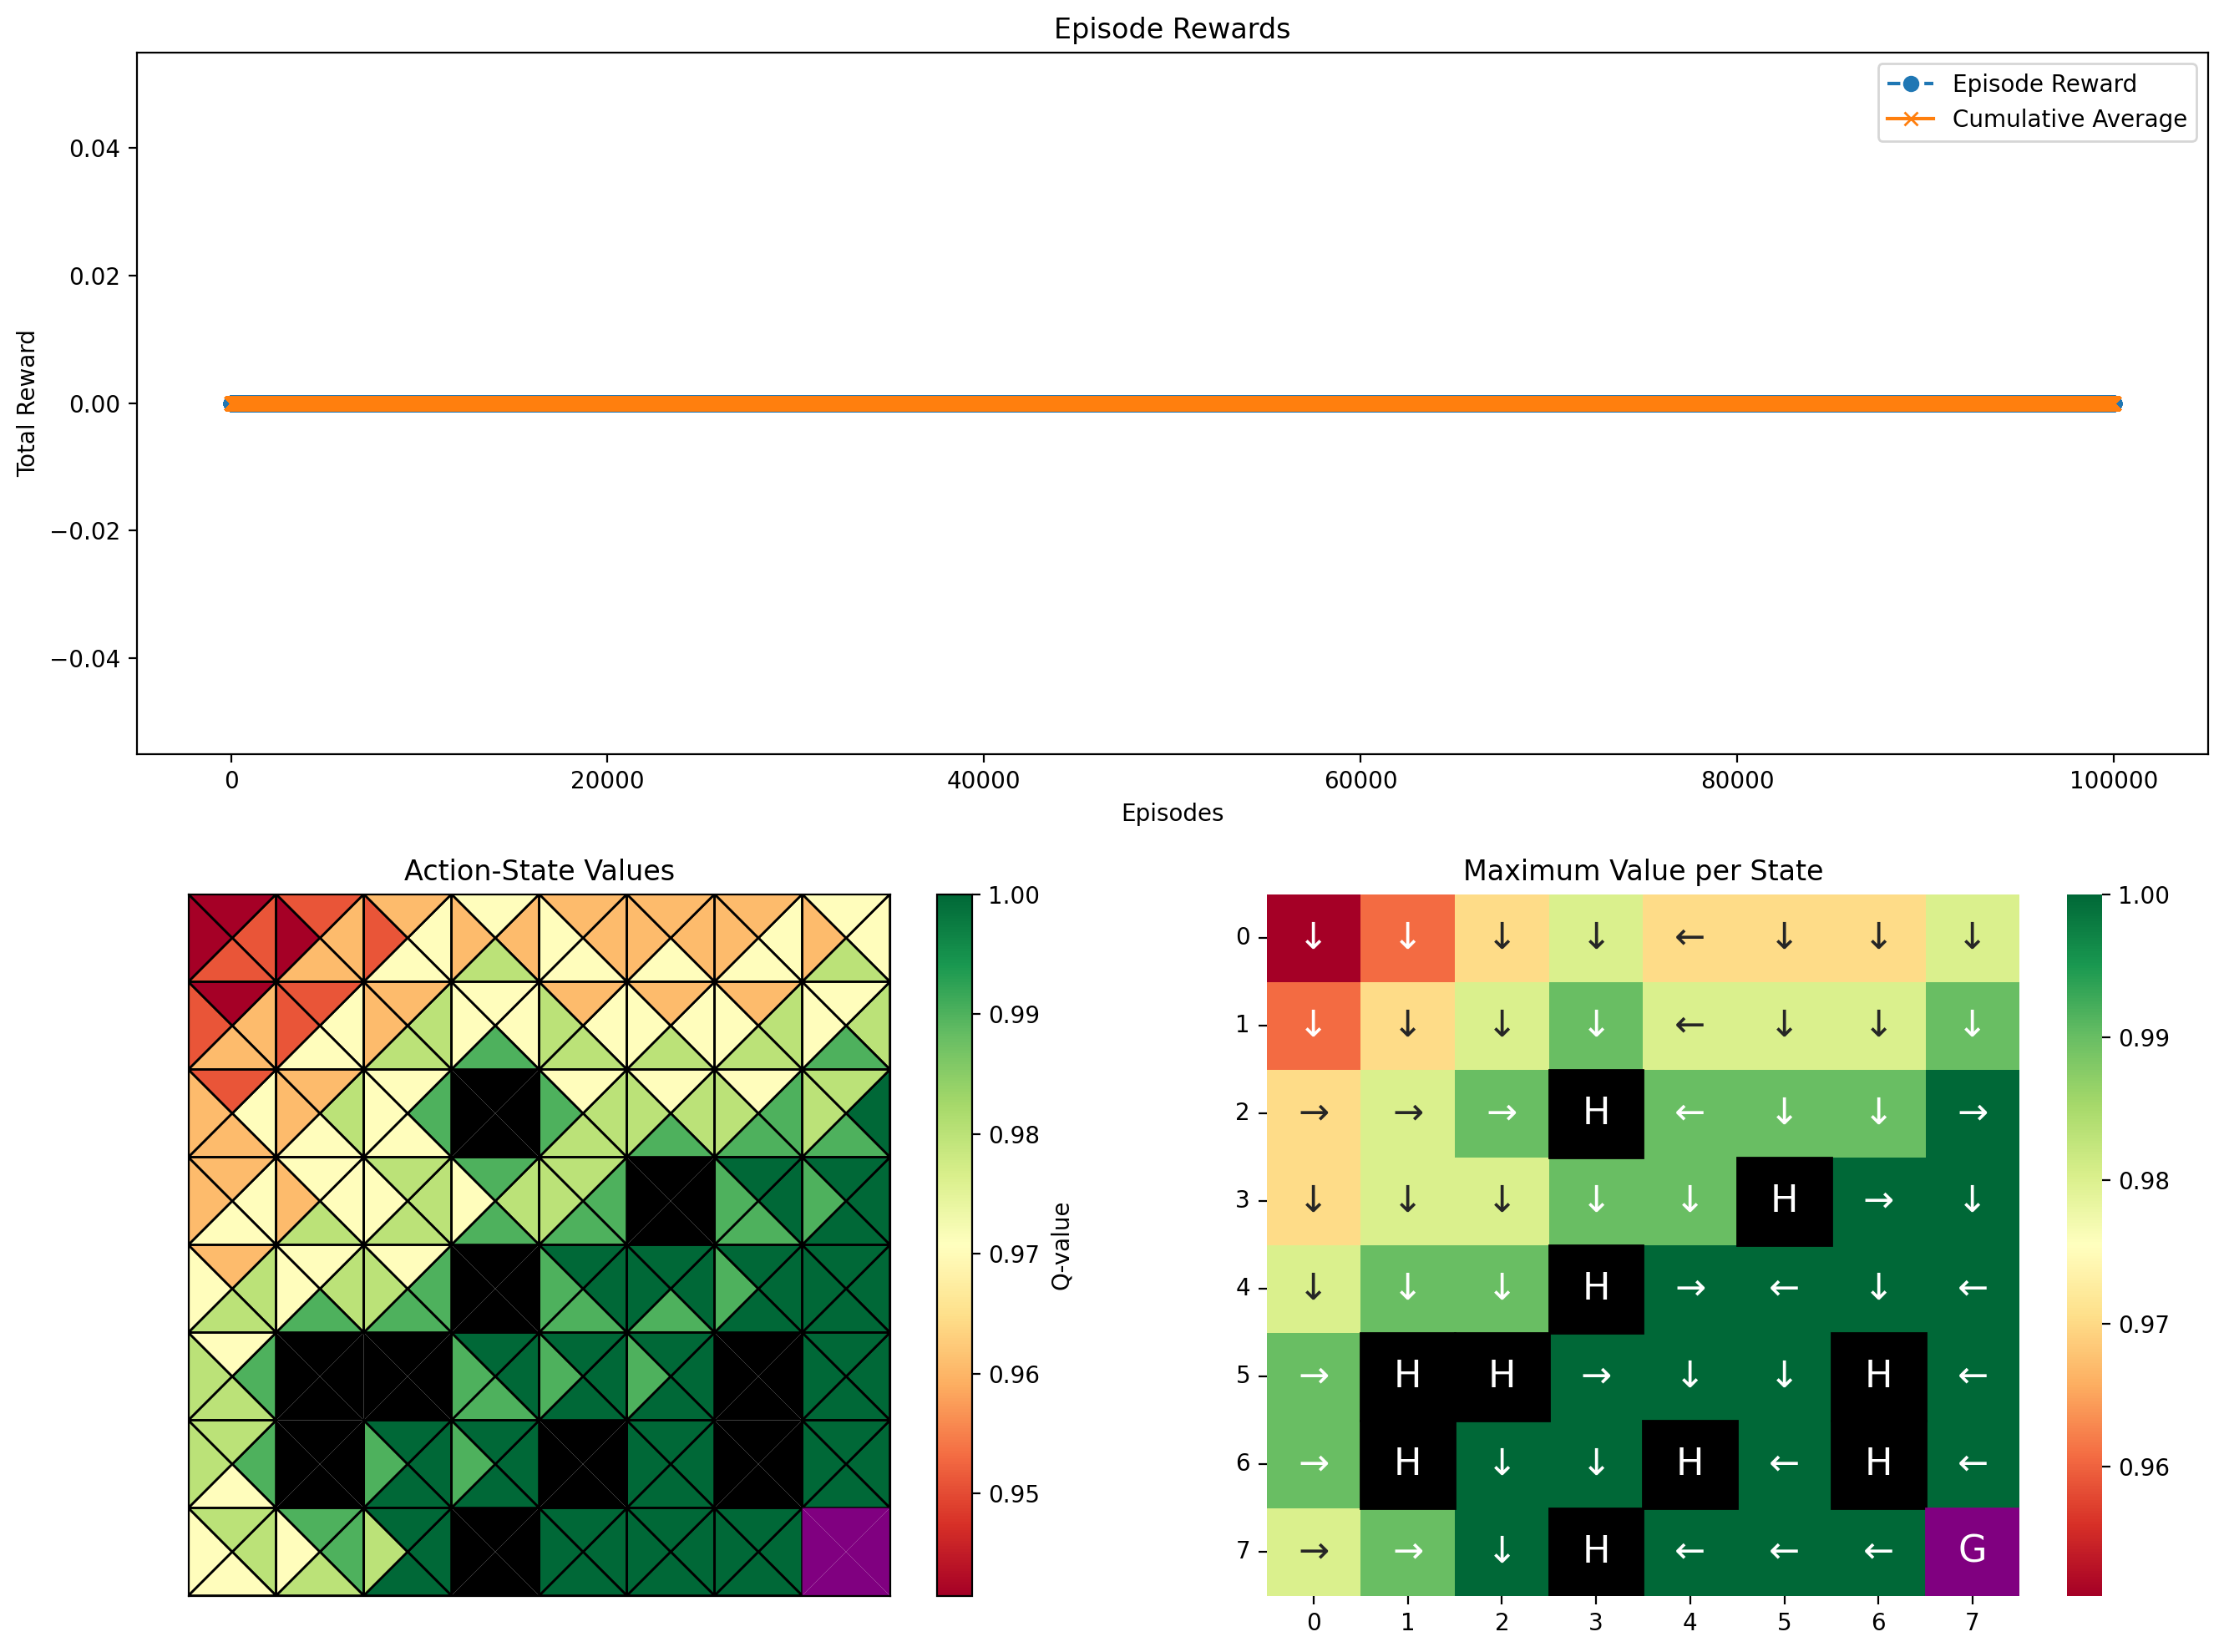

In [11]:
def dyna_q_optimistic(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
                      gamma: float, n: int, init_value: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Dyna-Q algorithm with optimistic initialization for Q-values.

    Parameters:
        n_episodes (int): Number of episodes to run.
        env (gym.Env): The Gym environment.
        epsilon (float): Exploration rate for the epsilon-greedy policy.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n (int): Number of planning steps.
        init_value (float): Initial optimistic value for Q-values.

    Returns:
        tuple: The final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    # Initialize Q-values optimistically instead of zeros.
    q = np.full((env.observation_space.n, env.action_space.n), init_value)

    # Deterministic model: mapping (state, action) to (reward, next_state)
    model = {}

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # Select action using epsilon-greedy policy based on the optimistic Q-values
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update
            q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

            # Update the deterministic model
            model[(state, action)] = (reward, next_state)

            # Perform planning steps using the model
            q = q_planning(model, q, alpha, gamma, n)

            # Move to next state and update cumulative reward
            state = next_state
            reward_sum += reward

        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Run the optimistic initialization experiment on the 8x8 FrozenLake deterministic environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
q_optimistic, rewards_optimistic = dyna_q_optimistic(100000, env, epsilon=0.1, alpha=0.1, gamma=0.99, n=50)
plot_performance(env, q_optimistic, rewards_optimistic)


### Experiment 2: Decaying Epsilon Schedule

**Modification:**  
Instead of using a fixed epsilon value for the ε‑greedy policy, we start with a high epsilon (encouraging exploration) and gradually decay it after each episode.

**Rationale:**  
A high initial epsilon allows the agent to explore the environment extensively when it has little prior knowledge. Over time, as the agent learns more about the environment, decaying epsilon reduces exploration in favor of exploiting the learned Q-values. This dynamic balance helps improve overall performance and convergence.

**Observations:**  
With the decaying epsilon schedule, you should observe that:
- The agent explores more initially and then shifts toward exploiting the best actions as learning progresses.
- Episode rewards increase as the agent refines its policy over time.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-2-98724c2daf64>:79: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - vmin) / (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


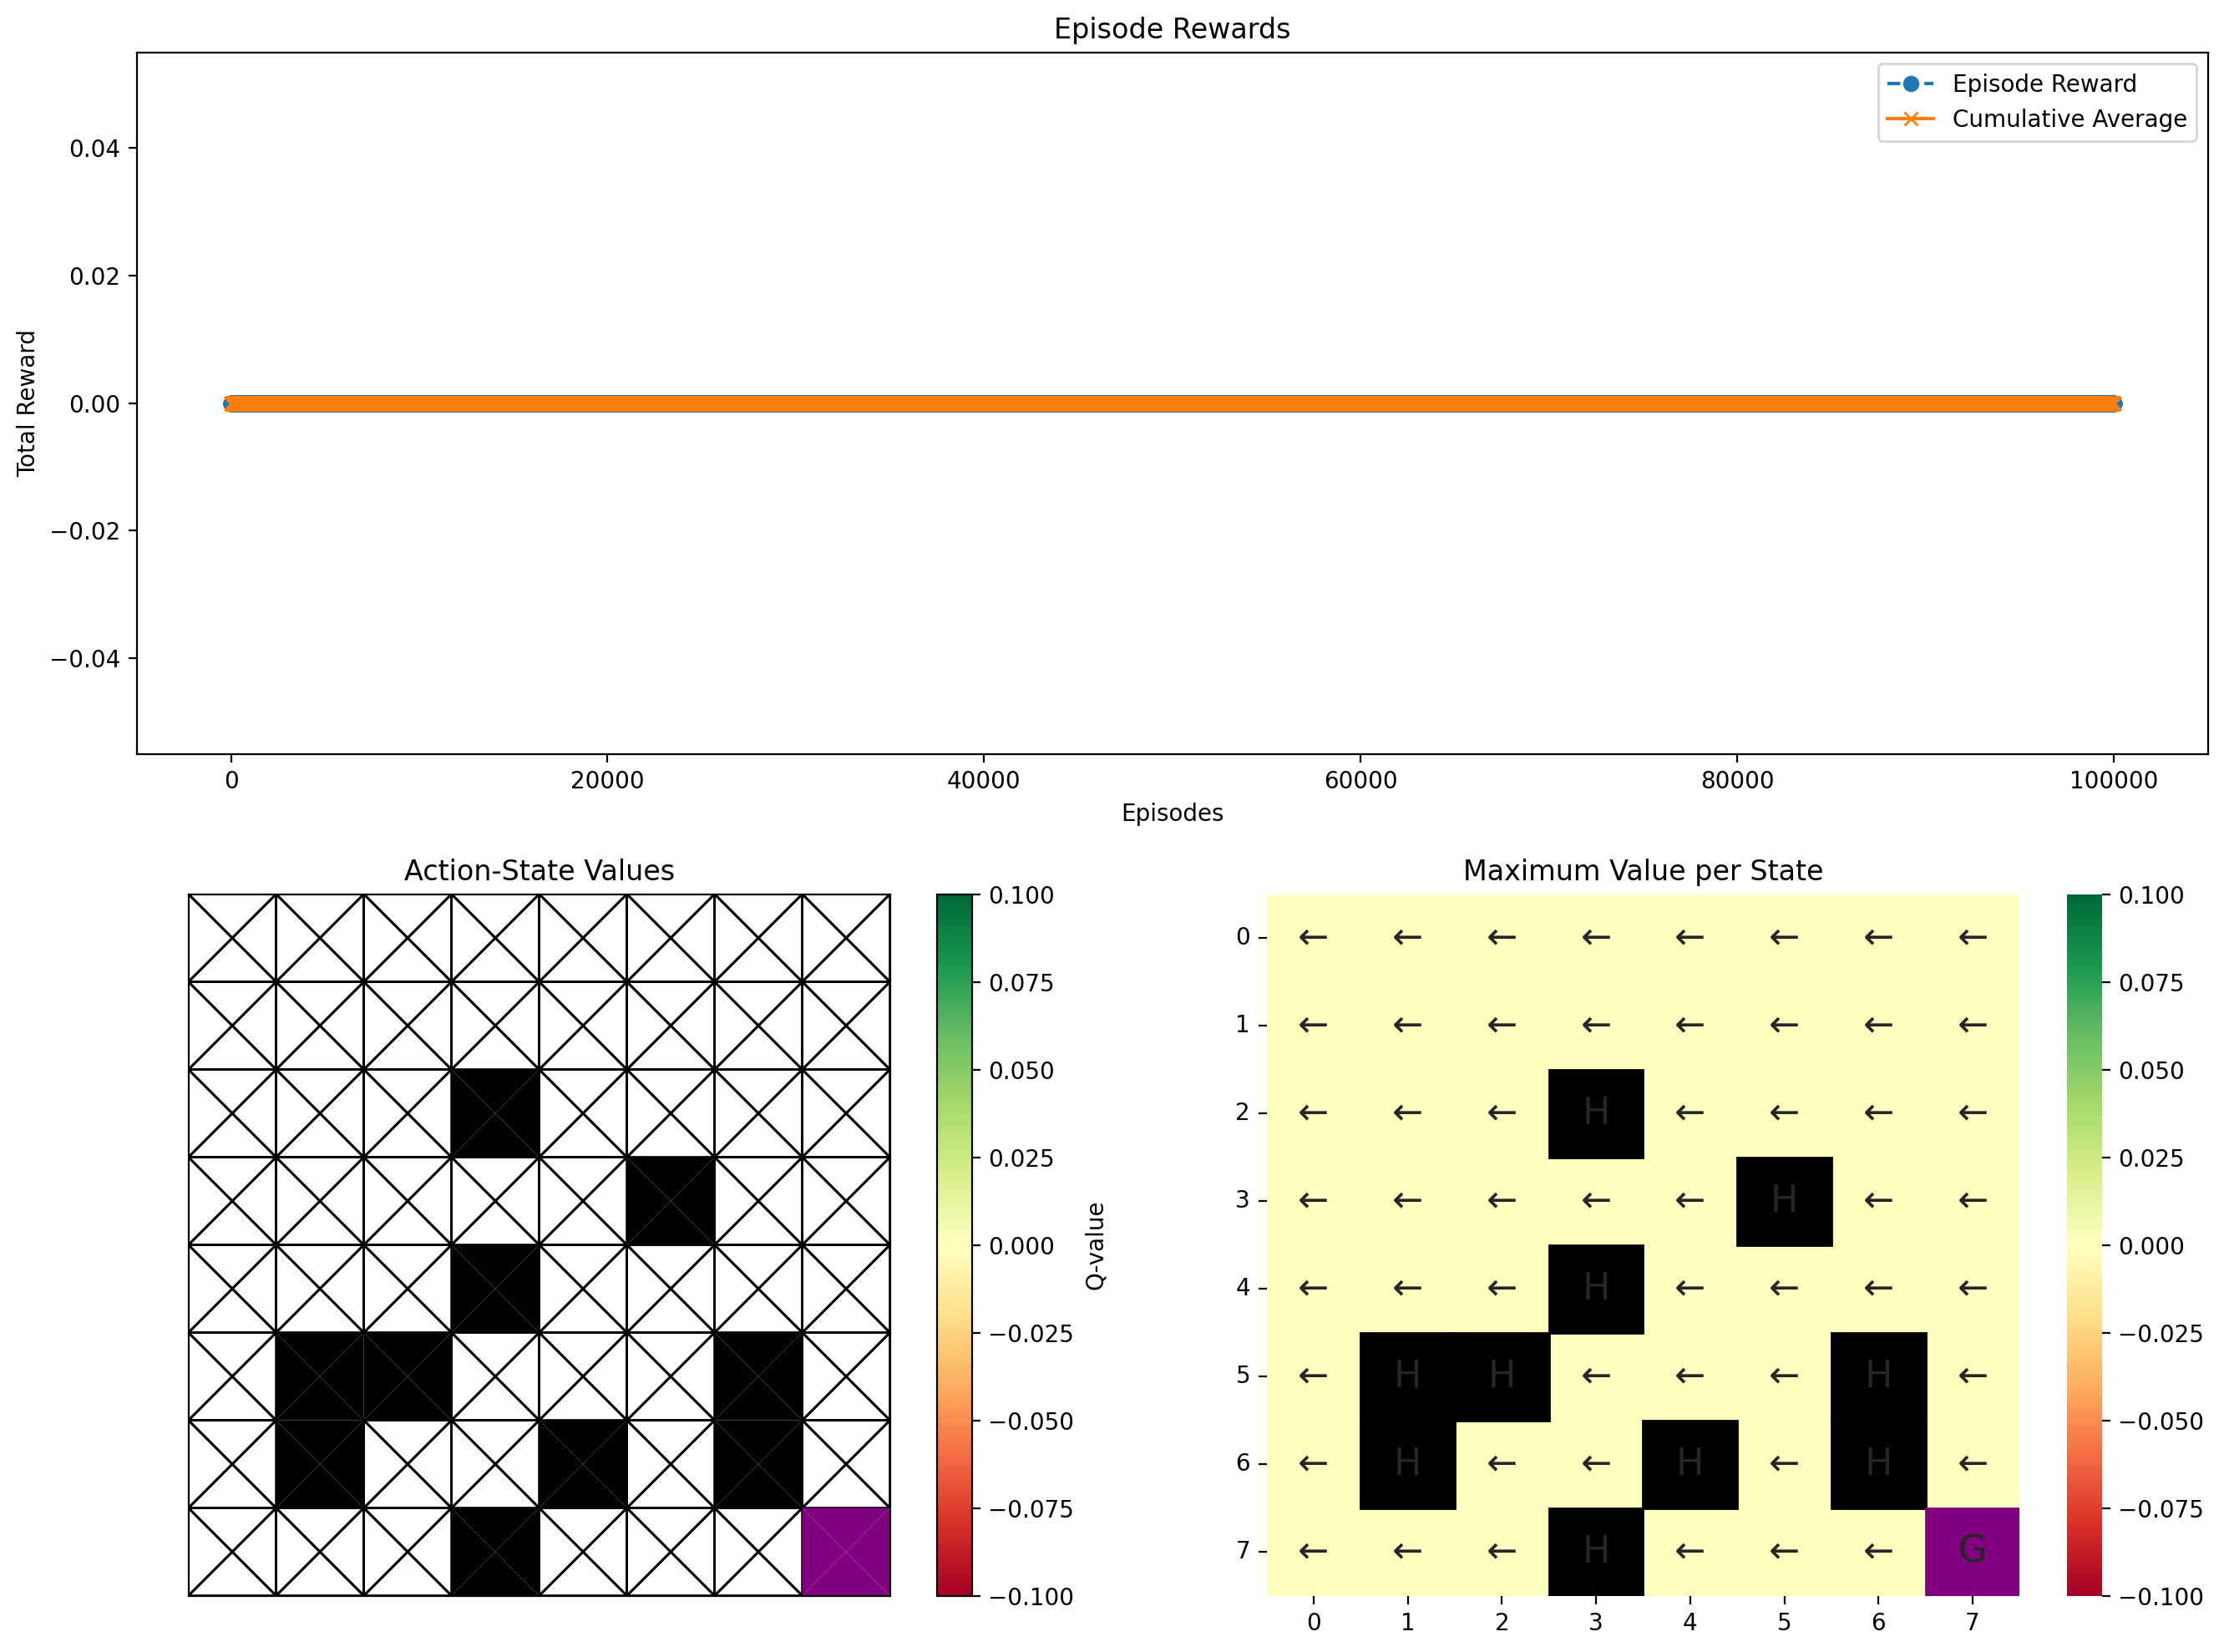

In [12]:
def dyna_q_decay_epsilon(n_episodes: int, env: gym.Env, epsilon_start: float, epsilon_decay: float, alpha: float,
                         gamma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Dyna-Q algorithm with a decaying epsilon schedule for exploration.

    Parameters:
        n_episodes (int): Number of episodes to run.
        env (gym.Env): The Gym environment.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Multiplicative factor to decay epsilon after each episode.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n (int): Number of planning steps.

    Returns:
        tuple: The final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    model = {}

    epsilon = epsilon_start

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # Select action using epsilon-greedy policy with decaying epsilon
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update
            q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])
            # Update the deterministic model
            model[(state, action)] = (reward, next_state)
            # Perform planning steps using the model
            q = q_planning(model, q, alpha, gamma, n)

            state = next_state
            reward_sum += reward

        # Decay epsilon after each episode
        epsilon *= epsilon_decay
        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Run the decaying epsilon experiment on the 8x8 FrozenLake deterministic environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
q_decay, rewards_decay = dyna_q_decay_epsilon(n_episodes=100000, env=env, epsilon_start=1.0, epsilon_decay=0.99, alpha=0.1, gamma=0.99, n=50)
plot_performance(env, q_decay, rewards_decay)


### Experiment 3: Adaptive Planning Steps

**Modification:**  
Instead of using a fixed number of planning steps for every episode, we adjust the number of planning steps dynamically as training progresses. In this example, we start with a higher number of planning steps and decay them over episodes.

**Rationale:**  
Early in training the model is less accurate, so more planning steps can help propagate the reward information faster. As the agent learns and the Q-values converge, reducing the planning steps can prevent overfitting to early experiences and save computation time.

**Observations:**  
With adaptive planning steps, you should observe that:
- Initially, the agent benefits from more planning updates.
- Over time, as the Q-values become more stable, fewer planning steps are required.
- Overall performance may improve compared to using a fixed number of planning steps.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-2-98724c2daf64>:79: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - vmin) / (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


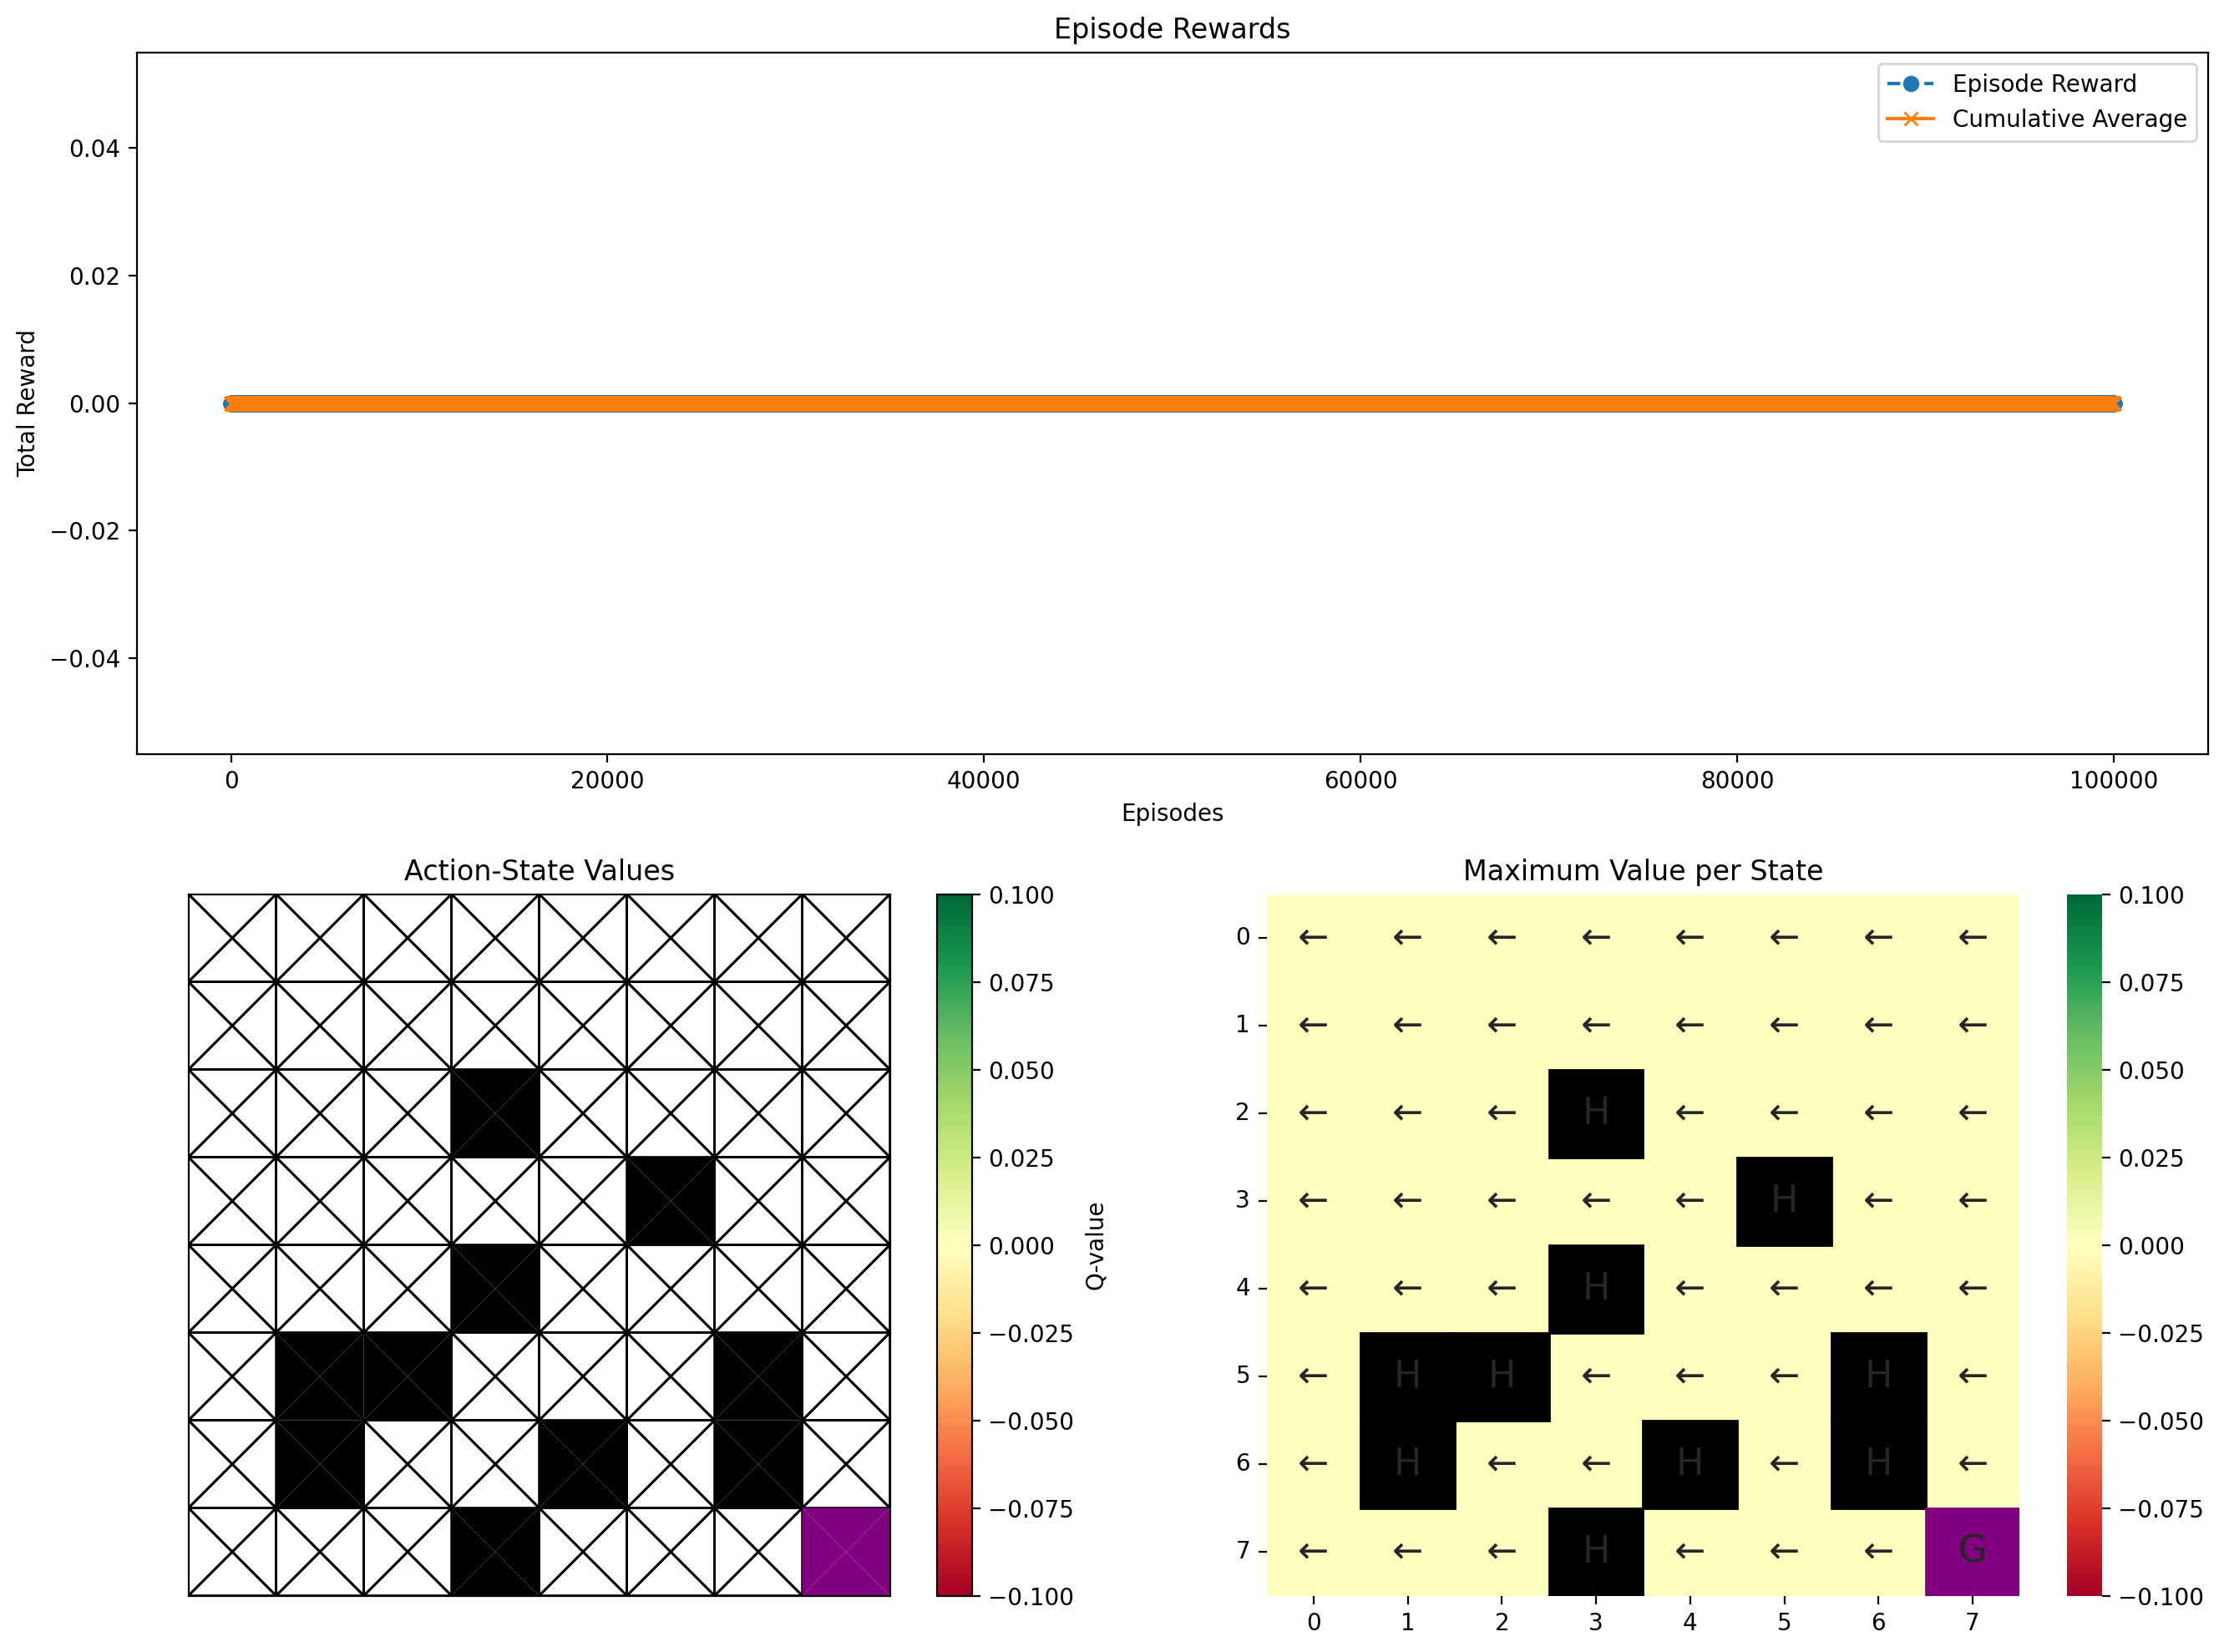

In [13]:
def dyna_q_adaptive_planning(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
                             gamma: float, n_initial: int, n_decay: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Dyna-Q algorithm with adaptive planning steps.

    Parameters:
        n_episodes (int): Number of episodes to run.
        env (gym.Env): The Gym environment.
        epsilon (float): Exploration rate for the epsilon-greedy policy.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n_initial (int): Initial number of planning steps.
        n_decay (float): Decay factor for planning steps per episode.

    Returns:
        tuple: The final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    model = {}

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        # Compute adaptive planning steps for current episode (at least 1 step)
        n_steps = max(1, int(n_initial * (n_decay ** episode_i)))

        while not terminal:
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update
            q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])
            # Update the deterministic model
            model[(state, action)] = (reward, next_state)
            # Perform planning steps with the adaptive planning steps count
            q = q_planning(model, q, alpha, gamma, n_steps)

            state = next_state
            reward_sum += reward

        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Run the adaptive planning experiment on the 8x8 FrozenLake deterministic environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
q_adaptive, rewards_adaptive = dyna_q_adaptive_planning(
    n_episodes=100000, env=env, epsilon=0.1, alpha=0.1, gamma=0.99, n_initial=50, n_decay=0.995
)
plot_performance(env, q_adaptive, rewards_adaptive)


### Experiment 4: Alternative Exploration Policy – Softmax Exploration

**Modification:**  
Instead of using the ε‑greedy strategy for action selection, we use a softmax (Boltzmann) policy. In softmax exploration, actions are chosen according to a probability distribution derived from the Q-values, where higher Q-values have higher probability but all actions have a chance to be selected.

**Rationale:**  
The softmax policy provides a smoother trade-off between exploration and exploitation. Rather than taking a completely random action with a fixed probability, the probability of selecting an action increases gradually with its estimated value. This can help the agent better discriminate between actions when the Q-values are close and improve learning performance.

**Observations:**  
With the softmax exploration policy, you may observe:
- A more nuanced exploration strategy where suboptimal actions are still occasionally selected.
- Improved convergence behavior as the agent gradually focuses on higher-value actions.
- Overall performance improvements compared to a strict ε‑greedy approach.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100000 [00:00<?, ?it/s]

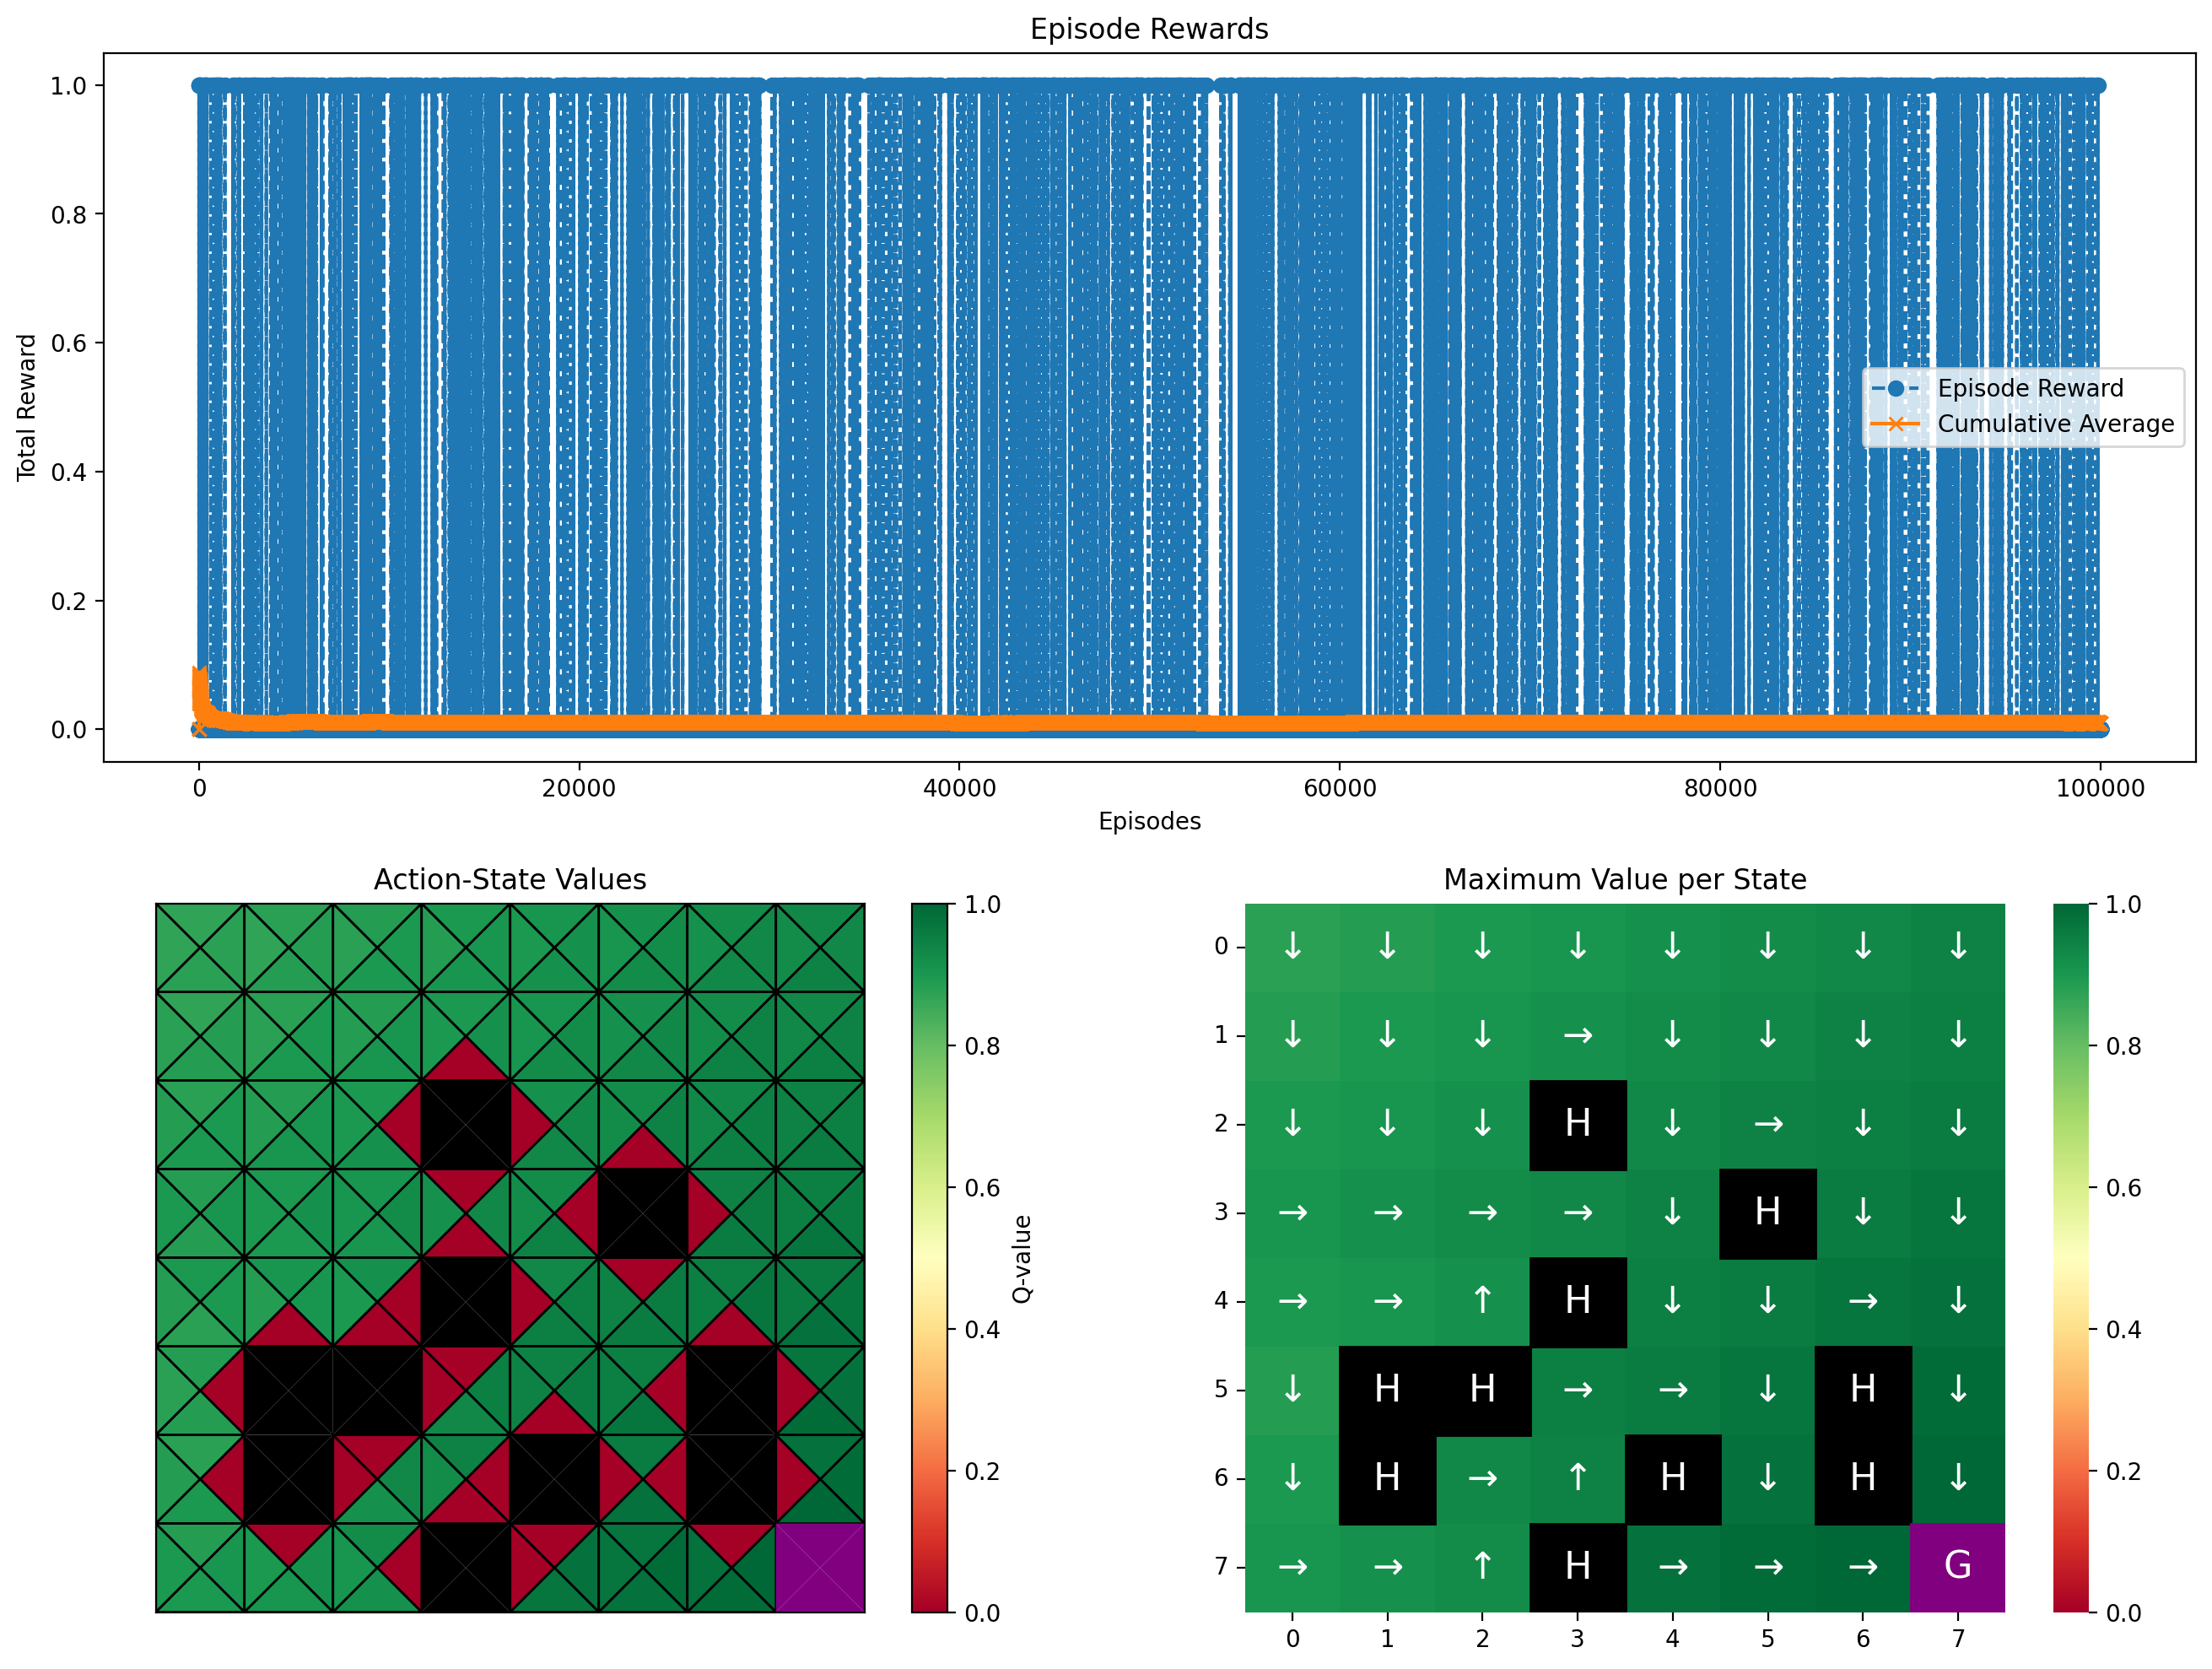

In [14]:
def softmax_policy(state: int, q_values: np.ndarray, tau: float) -> int:
    """
    Select an action based on a softmax (Boltzmann) distribution over Q-values.

    Parameters:
        state (int): Current state index.
        q_values (np.ndarray): Q-values array.
        tau (float): Temperature parameter controlling exploration (higher tau -> more exploration).

    Returns:
        int: Selected action.
    """
    # Retrieve Q-values for the current state and subtract max for numerical stability.
    q_state = q_values[state]
    exp_q = np.exp((q_state - np.max(q_state)) / tau)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_state), p=probs)

def dyna_q_softmax(n_episodes: int, env: gym.Env, tau: float, alpha: float,
                   gamma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Dyna-Q algorithm using a softmax exploration policy.

    Parameters:
        n_episodes (int): Number of episodes to run.
        env (gym.Env): The Gym environment.
        tau (float): Temperature parameter for the softmax policy.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n (int): Number of planning steps.

    Returns:
        tuple: The final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    model = {}

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # Select an action using the softmax policy
            action = softmax_policy(state, q, tau)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update
            q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

            # Update the deterministic model with the observed transition
            model[(state, action)] = (reward, next_state)
            # Planning steps using the learned model
            q = q_planning(model, q, alpha, gamma, n)

            state = next_state
            reward_sum += reward

        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Run the softmax exploration experiment on the 8x8 FrozenLake deterministic environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
q_softmax, rewards_softmax = dyna_q_softmax(n_episodes=100000, env=env, tau=1.0, alpha=0.1, gamma=0.99, n=50)
plot_performance(env, q_softmax, rewards_softmax)


### Experiment 5: Combined Improvements with Adjusted Parameters

**Modifications:**  
- **Optimistic Initialization:** Q-values are initialized optimistically (e.g., to 1.0) so that unexplored actions appear promising.
- **Decaying Epsilon Schedule (Slower Decay):** The exploration rate starts high (1.0) and decays more slowly (e.g., epsilon_decay=0.999) so that the agent continues to explore for longer.  
- **Adaptive Planning Steps (Slower Decay):** The number of planning steps is also decayed slowly, allowing more planning in the early episodes when learning is sparse.
- **Increased Episodes:** We increase the number of episodes (e.g., to 2000) to give the agent enough time to discover the goal in this sparse-reward setting.

**Rationale:**  
In a large and sparse environment like the 8x8 deterministic FrozenLake, the agent might not discover the goal quickly, leading to many episodes with 0 reward. By keeping epsilon high for longer and performing more planning early on, the agent is more likely to explore diverse paths and eventually find the rewarding goal state.

**Observations:**  
With these adjustments, you should expect:
- A higher probability of the agent discovering the goal.
- A gradual increase in episode rewards as the agent learns the optimal path.
- More effective propagation of reward information via planning.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100000 [00:00<?, ?it/s]

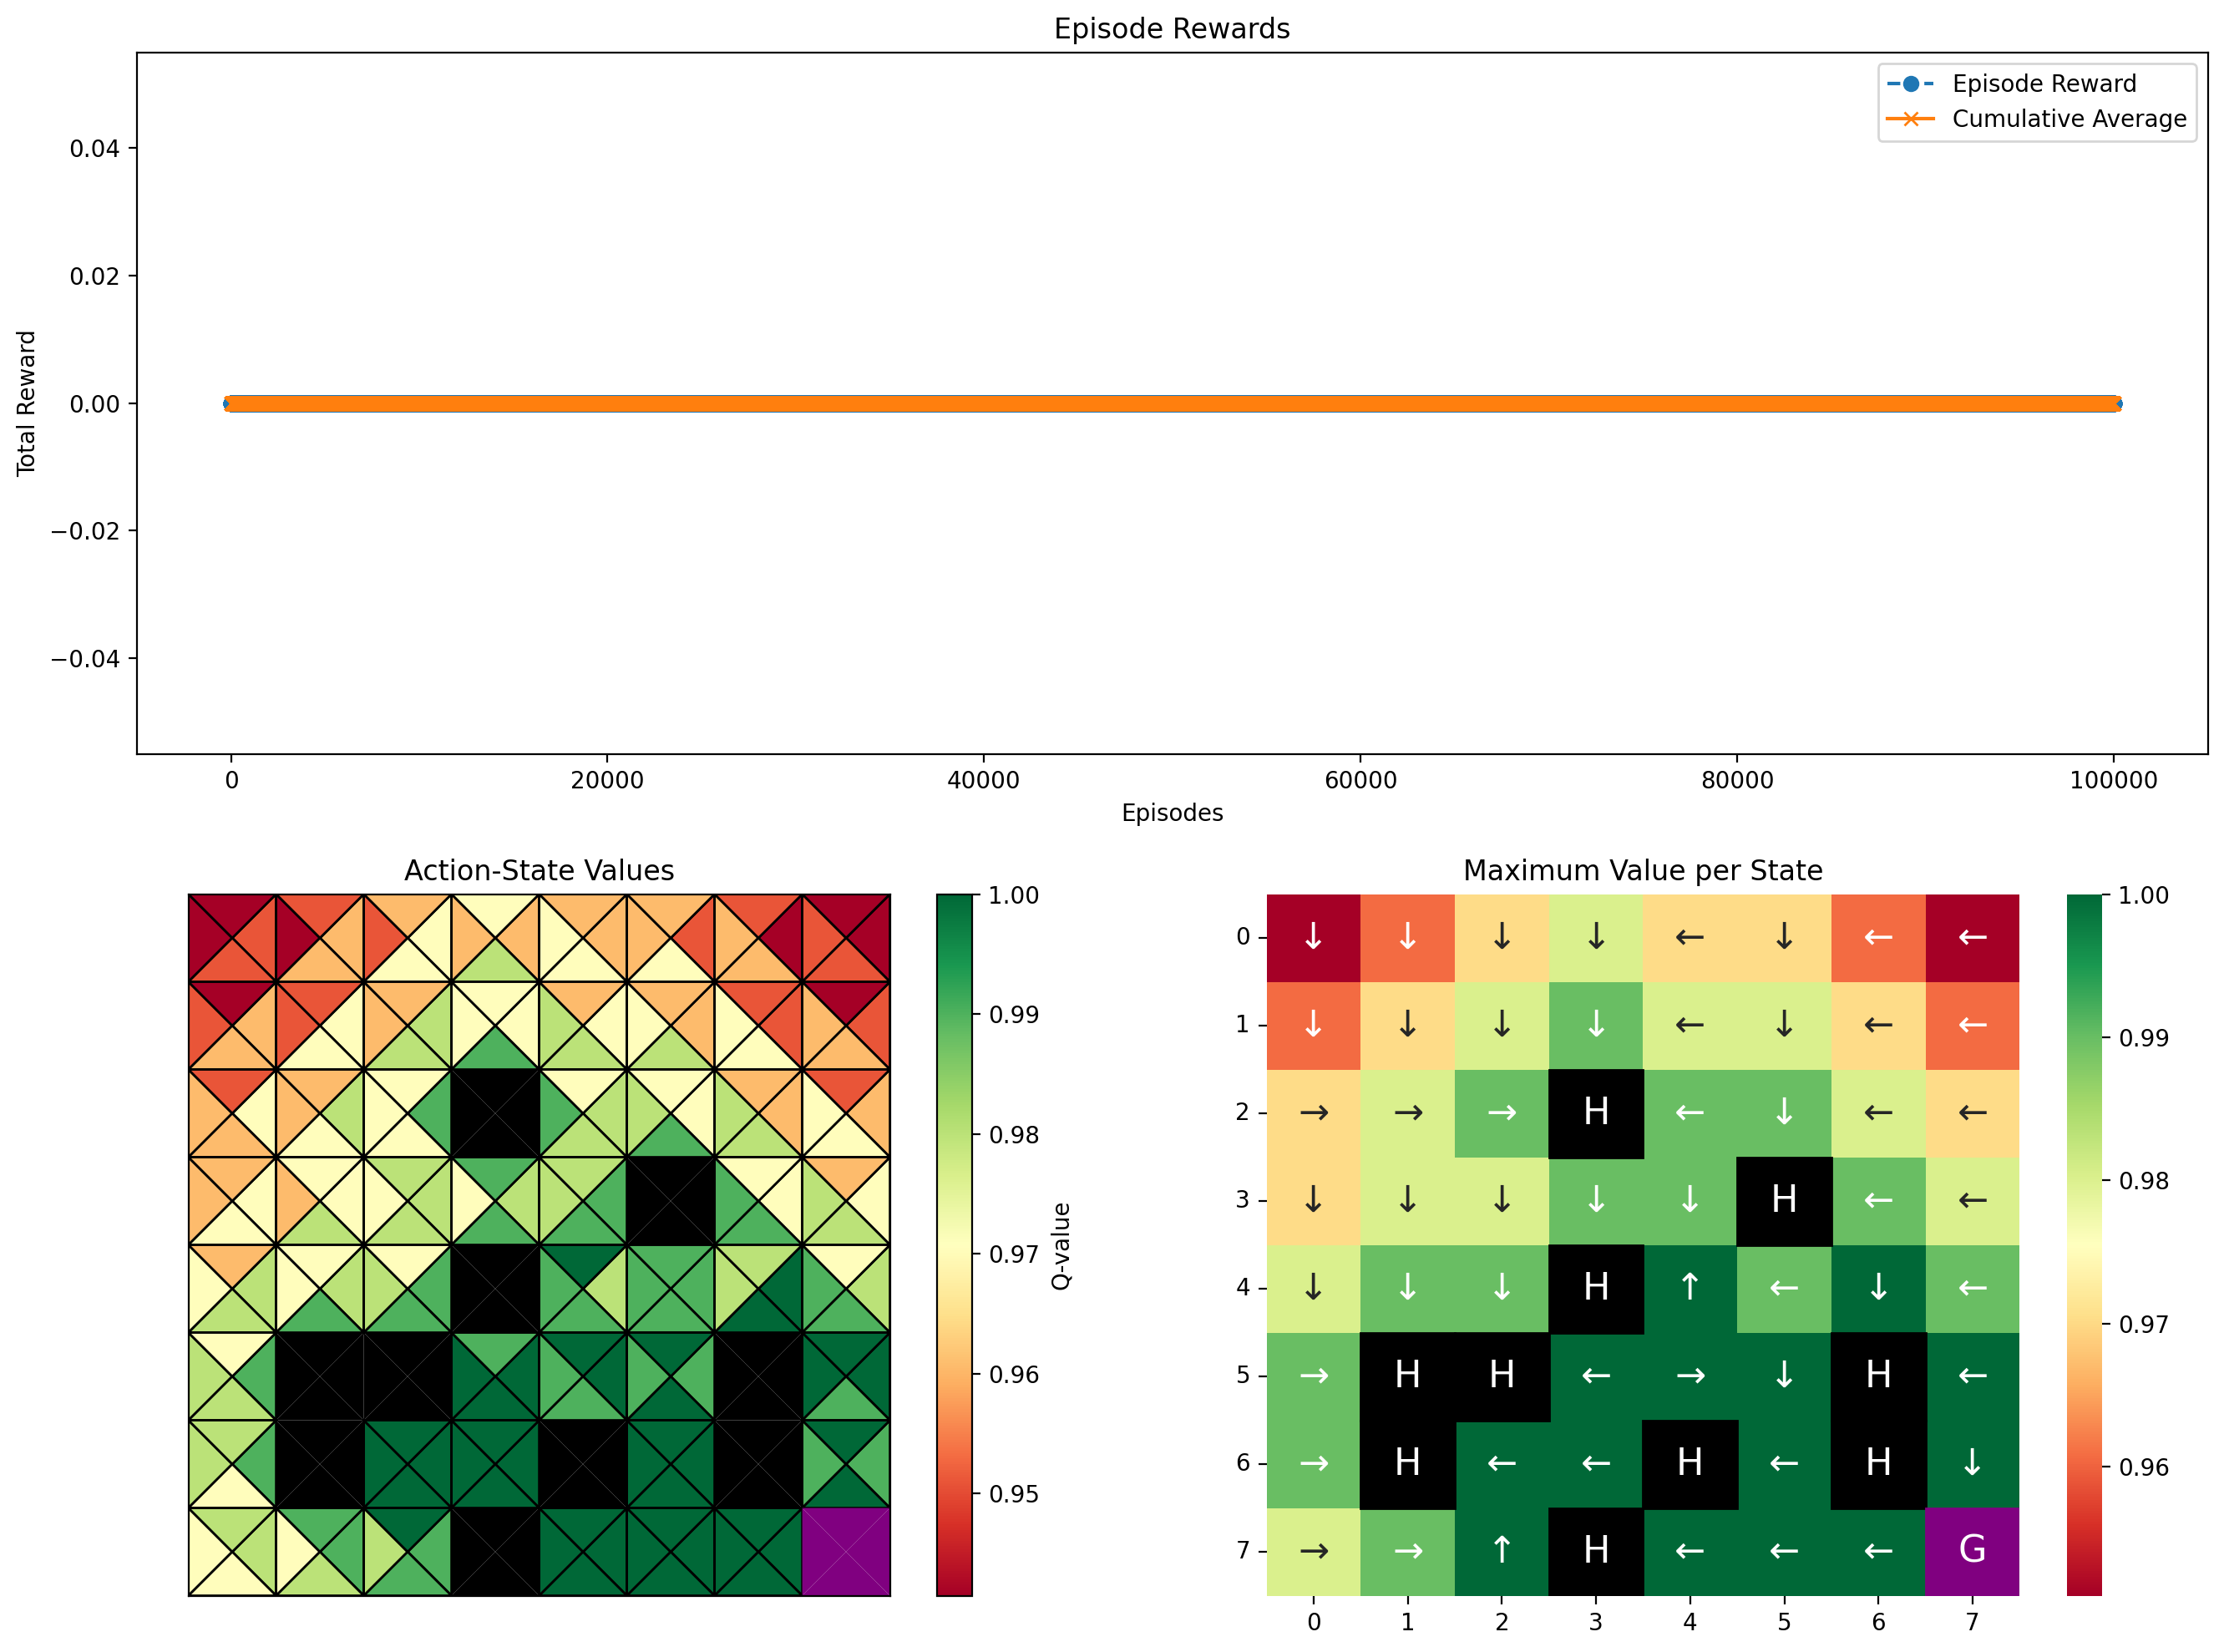

In [15]:
def dyna_q_combined(n_episodes: int, env: gym.Env, epsilon_start: float, epsilon_decay: float,
                    alpha: float, gamma: float, n_initial: int, n_decay: float, init_value: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Combined Dyna-Q algorithm with multiple improvements:
    - Optimistic initialization for Q-values.
    - Decaying epsilon schedule for exploration (with slower decay).
    - Adaptive planning steps (with slower decay).

    Parameters:
        n_episodes (int): Number of episodes to run.
        env (gym.Env): The Gym environment.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Multiplicative decay factor for epsilon after each episode.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n_initial (int): Initial number of planning steps.
        n_decay (float): Decay factor for planning steps per episode.
        init_value (float): Initial optimistic value for Q-values.

    Returns:
        tuple: Final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    # Optimistically initialize Q-values
    q = np.full((env.observation_space.n, env.action_space.n), init_value)

    model = {}
    epsilon = epsilon_start

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        # Adaptive planning steps for current episode (at least 1 step)
        n_steps = max(1, int(n_initial * (n_decay ** episode_i)))

        while not terminal:
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Q-learning update with real experience
            q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

            # Update the deterministic model with the new transition
            model[(state, action)] = (reward, next_state)

            # Perform planning steps using the model
            q = q_planning(model, q, alpha, gamma, n_steps)

            state = next_state
            reward_sum += reward

        # Decay the exploration rate
        epsilon *= epsilon_decay
        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Adjusted parameters to encourage exploration and allow more time for learning
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
q_combined, rewards_combined = dyna_q_combined(
    n_episodes=100000,          # Increased episodes for sparse rewards
    env=env,
    epsilon_start=1.0,
    epsilon_decay=0.999,      # Slower decay so that exploration continues longer
    alpha=0.1,
    gamma=0.99,
    n_initial=50,
    n_decay=0.999,            # Slower decay of planning steps
    init_value=1.0
)
plot_performance(env, q_combined, rewards_combined)


### Why Are We Observing 0 Total Reward in All Experiments?

There are several factors that could be contributing to the persistent 0 total reward:

- **Sparse Reward Structure:**  
  In FrozenLake, the only positive reward is given when the agent reaches the goal state. Every other transition returns 0. If the agent never finds the goal, the episode's cumulative reward remains 0.

- **Large State Space and Long Horizon:**  
  The 8x8 FrozenLake environment has 64 states, and reaching the goal may require a long sequence of precise actions. Random exploration—even when improved—may rarely stumble upon the optimal sequence, leading to no reward.

- **Insufficient Exploration:**  
  Although modifications like optimistic initialization and decaying epsilon are designed to boost exploration, the balance might still be insufficient. If the agent reduces exploration too early or does not explore critical states enough, it might never discover the rewarding state.

- **Ineffective Reward Propagation:**  
  Without ever experiencing a positive reward, the Q-value updates are based solely on 0 rewards. This makes it challenging to propagate the value of reaching the goal back through the state-action space.

- **Hyperparameter Sensitivity:**  
  Parameters such as the learning rate (α), discount factor (γ), epsilon decay, and planning steps have a significant impact on learning. Suboptimal settings in a sparse-reward environment can prevent the agent from learning the necessary behavior to reach the goal.

- **Deterministic Environment Dynamics:**  
  Although a deterministic environment (non-slippery FrozenLake) should, in theory, help the agent once a successful path is discovered, the initial discovery might be very unlikely if the exploration strategy is not aggressive enough.

**Conclusion:**  
The consistent 0 total reward suggests that the agent is not discovering the goal state. This is primarily due to the sparse rewards and the complexity of finding a long sequence of correct actions in a large state space. Further experimentation might include:
- Increasing the number of episodes significantly.
- Enhancing exploration strategies (e.g., more aggressive epsilon decay or alternative policies).
- Introducing reward shaping to provide intermediate signals.
- Tuning the hyperparameters even more finely.

These modifications could help the agent eventually discover the goal, enabling the propagation of non-zero rewards through Q-learning updates.


# Reward Shaping (10 points)

As you know, [Reward Function Design is Difficult](https://www.alexirpan.com/2018/02/14/rl-hard.html#reward-function-design-is-difficult).
However there a few main principles than can help speed up *Temporal-Difference Learning*.
Here we ask you to modify the reward function to achieve better results.

In [16]:
from gymnasium.envs.toy_text import FrozenLakeEnv

class CustomFrozenLakeEnv(FrozenLakeEnv):
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        # Modify the reward calculation using the custom reward function
        reward = self.custom_reward_function(obs, reward, terminated)
        return obs, reward, terminated, truncated, info

    def custom_reward_function(self, observation, reward, done):
        # Compute row and column indices from the observation
        rows, cols = self.desc.shape
        row, col = divmod(observation, cols)
        tile = self.desc[row, col]

        # Define custom reward logic:
        # - Goal (G): Give a high positive reward.
        # - Hole (H): Give a high negative reward.
        # - Frozen (F): Give a small negative reward (step penalty) to encourage faster completion.
        if tile == b'G':
            custom_reward = 10.0
        elif tile == b'H':
            custom_reward = -10.0
        else:
            custom_reward = -0.1

        return custom_reward


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Experiment with the new environment and improved reward function.

Explanin how your modifications improved the results.

`Your Answer:`

  0%|          | 0/100000 [00:00<?, ?it/s]

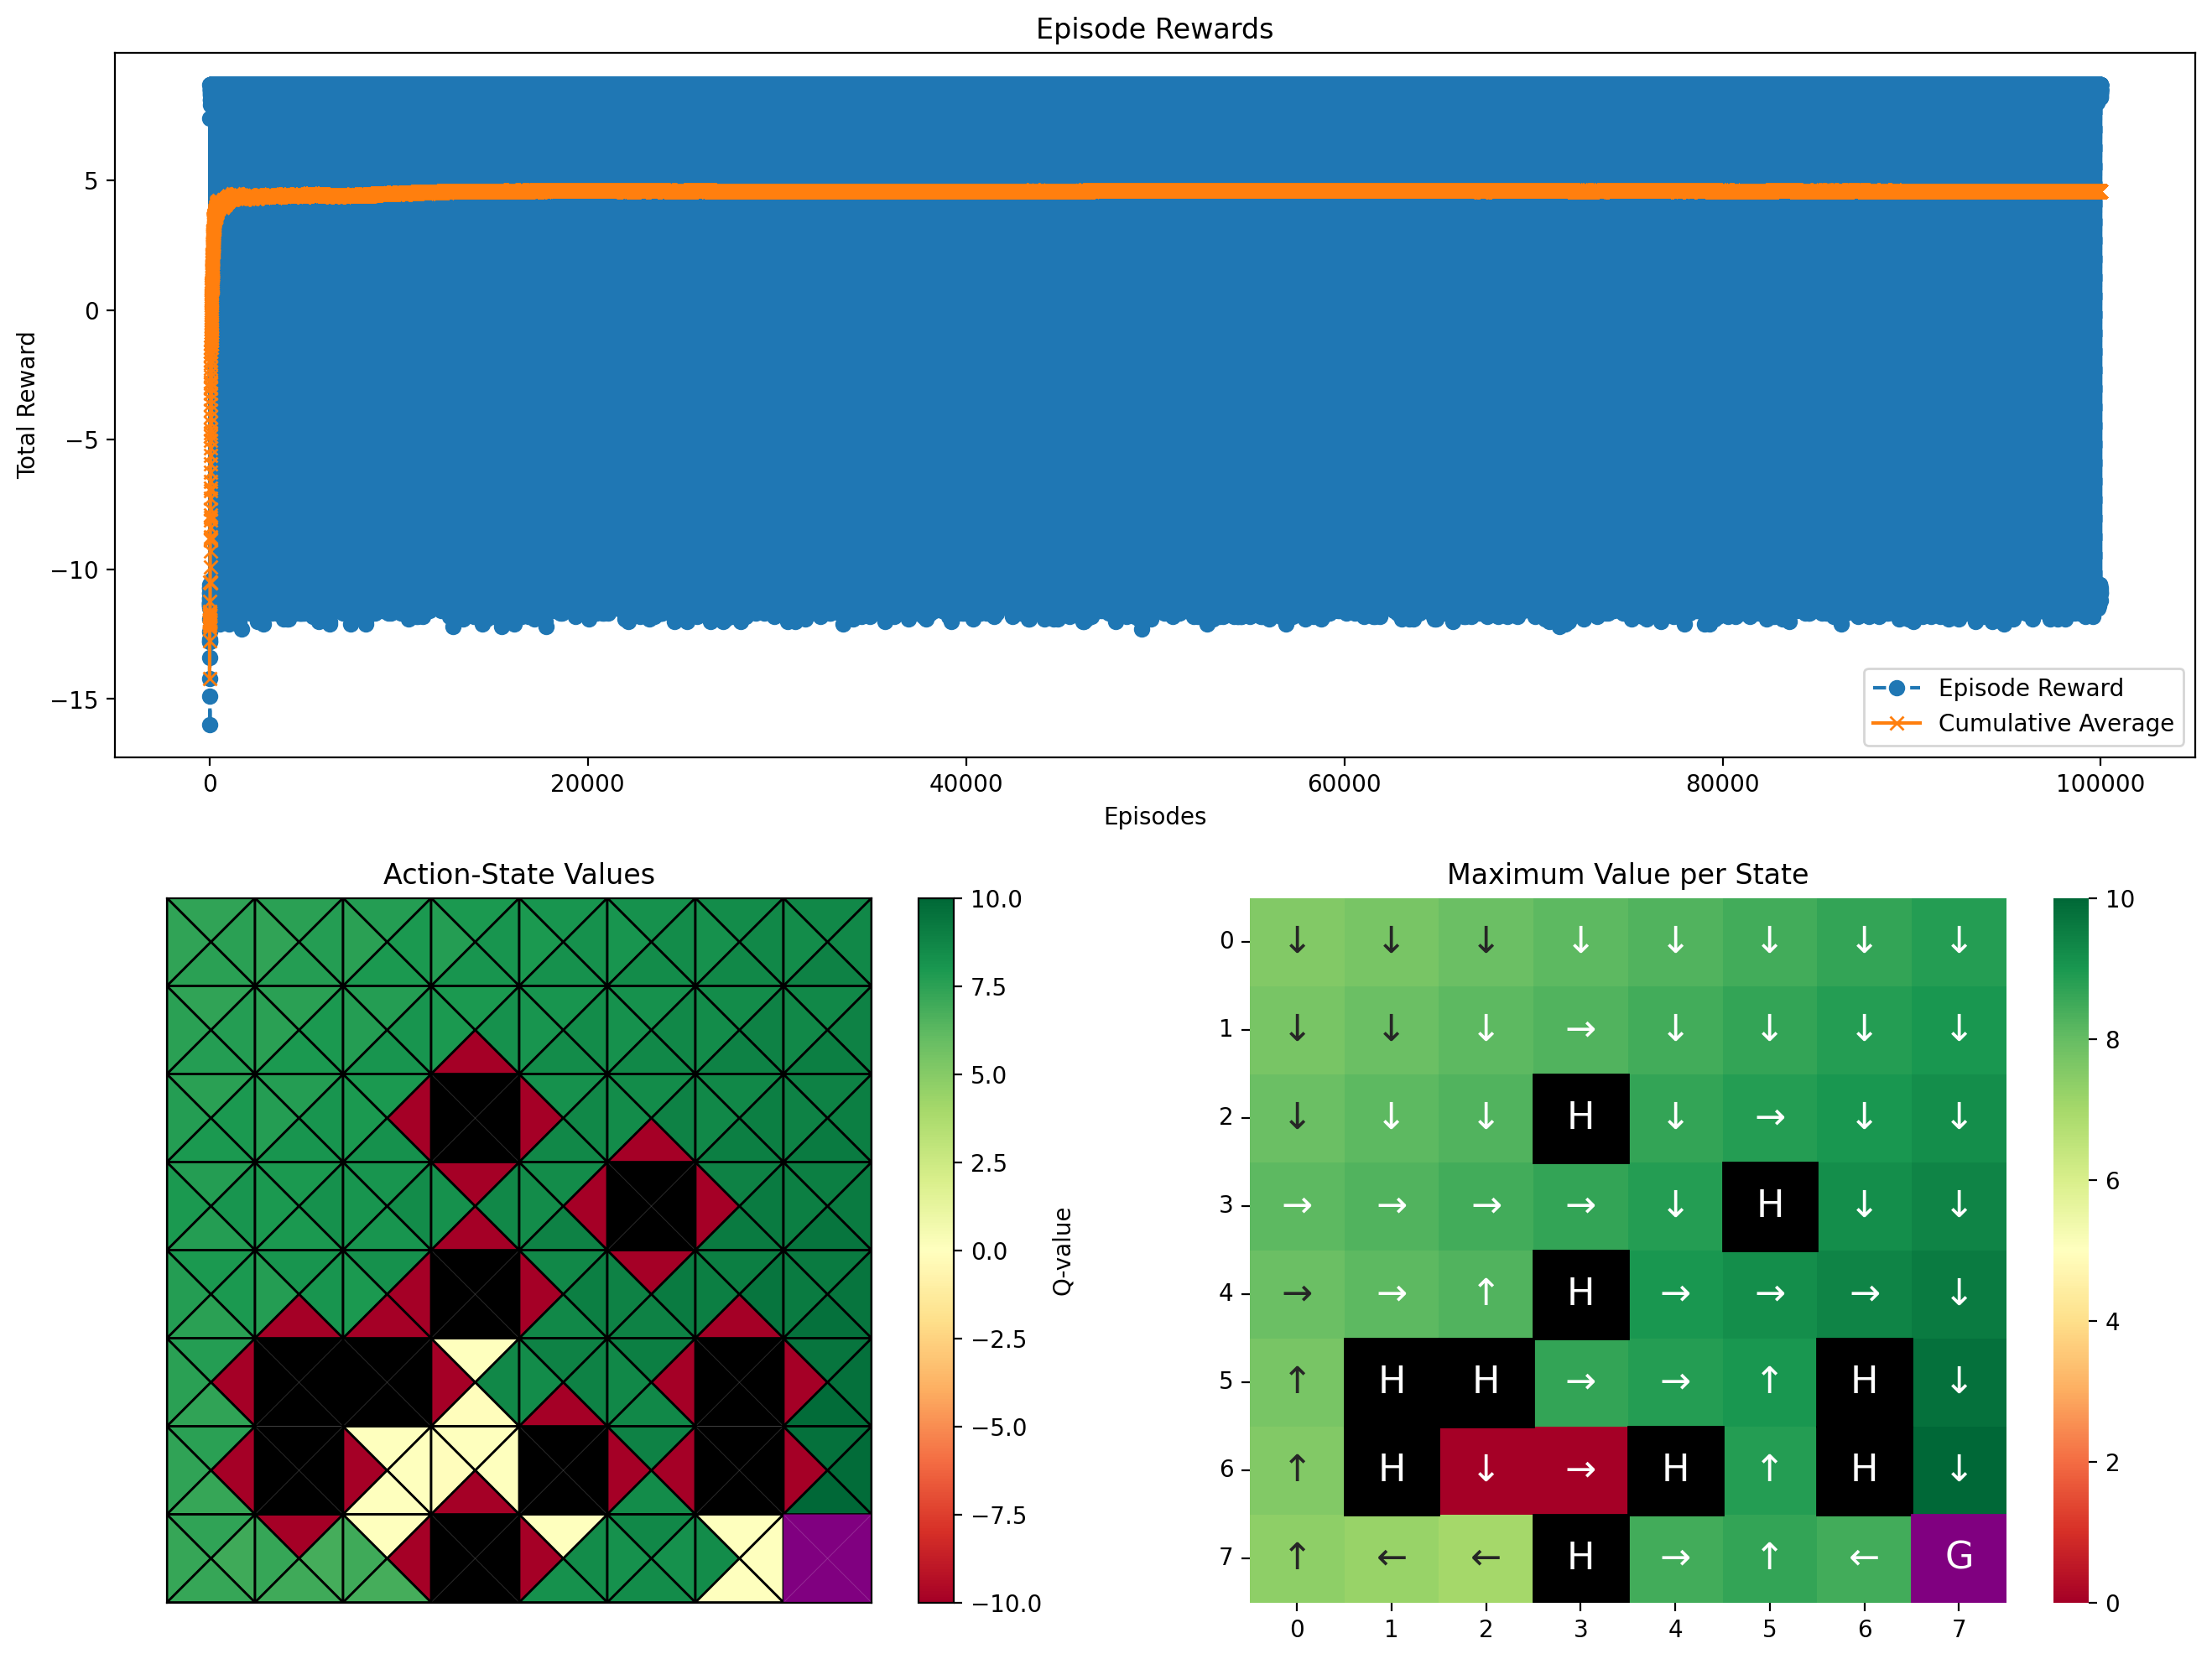

In [17]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'epsilon': 0.1,    # exploration rate for epsilon-greedy policy
          'alpha': 0.1,      # learning rate
          'gamma': 0.99,     # discount factor
          'n': 50,           # number of planning steps
}

# episodes/trials
n_episodes = 100000

# environment initialization using our CustomFrozenLakeEnv with improved reward shaping
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=False)

# Solve FrozenLake using Dyna-Q with reward shaping
value_dyna_q, reward_sums_dyna_q = dyna_q(n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)


# Prioritized Sweeping (20 points)

In the Dyna agents presented in the preceding sections, simulated transitions are started in state-action pairs selected uniformly at random from all previously experienced pairs.
But a uniform selection is usually not the best; planning can be much more efficient if simulated transitions and updates are focused on particular state-action pairs.

## Priority Planning (10 points)

The `q_planning_priority` function performs planning updates using **Prioritized Sweeping** by first checking if the priority queue is empty and then iterating for a specified number of planning steps.
It pops the state-action pair with the highest priority from the queue, retrieves the deterministic transition, and updates the Q-value using the temporal-difference (TD) error.
Next, it updates priorities for predecessor state-action pairs that transition to the current state, calculating their TD errors and pushing significant ones back into the priority queue.

In [18]:
def q_planning_priority(model: dict, q: np.ndarray, priorities: list, alpha: float, gamma: float, n: int) -> np.ndarray:
    """Performs planning updates using Prioritized Sweeping.

    Arguments:
      model: Dictionary mapping (state, action) pairs to (reward, next_state).
      q: The Q-values array.
      priorities: A priority queue (implemented as a list) with entries of the form
                  (-priority, (state, action)). (Negative priorities are used to simulate a max-heap.)
      alpha: Learning rate.
      gamma: Discount factor.
      n: Number of planning steps.

    Returns:
      The updated Q-values array.
    """
    theta = 0.1  # Threshold for significant TD error to update predecessors

    for _ in range(n):
        if not priorities:  # If the priority queue is empty, break out of the loop
            break

        # Pop the state-action pair with the highest priority (lowest negative value)
        neg_priority, (state, action) = heappop(priorities)
        # Retrieve the deterministic transition from the model
        if (state, action) not in model:
            continue
        reward, next_state = model[(state, action)]

        # Compute the TD error and update the Q-value
        td_error = reward + gamma * np.max(q[next_state]) - q[state, action]
        q[state, action] += alpha * td_error

        # For each predecessor (state', action') that leads to this state,
        # update its priority if the TD error is significant.
        for (pred_state, pred_action), (pred_reward, pred_next_state) in model.items():
            if pred_next_state == state:
                pred_td_error = pred_reward + gamma * np.max(q[state]) - q[pred_state, pred_action]
                if abs(pred_td_error) > theta:
                    # Push with negative absolute TD error to simulate a max-heap
                    heappush(priorities, (-abs(pred_td_error), (pred_state, pred_action)))

    return q


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Learning with Prioritized Sweeping (10 points)

Similar to the original `dyna_q` function, you need to implement the `dyna_q_priority`.
This time you must also store priorities and use a threshold parameter $\theta$ that determines whether a state-action pair should be added to the priority queue based on the magnitude of the temporal-difference (TD) error.

Specifically, $\theta$ is used to filter out small TD errors that are considered insignificant.
When the absolute value of the TD error for a state-action pair is greater than $\theta$, the pair is added to the priority queue.
This ensures that only state-action pairs with significant TD errors are prioritized for planning updates.

In [19]:
def dyna_q_priority(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
                    gamma: float, n: int, theta: float) -> tuple[np.ndarray, np.ndarray]:
    """Dyna-Q with Prioritized Sweeping algorithm for deterministic environments."""

    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Deterministic model: mapping (state, action) to (reward, next_state)
    model = {}

    # Priority queue for prioritized sweeping: store entries as (-priority, (state, action))
    priorities = []

    for episode_i in (pbar := trange(n_episodes, leave=False)):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # Take epsilon-greedy action
            action = epsilon_greedy_policy(state, q, epsilon)

            # Execute the action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Compute the temporal-difference (TD) error for the real experience
            td_error = reward + gamma * np.max(q[next_state]) - q[state, action]

            # Q-learning update from real experience
            q[state, action] += alpha * td_error

            # Update the deterministic model with the observed transition
            model[(state, action)] = (reward, next_state)

            # If the absolute TD error is above the threshold, add to priority queue
            if abs(td_error) > theta:
                heappush(priorities, (-abs(td_error), (state, action)))

            # Planning step using prioritized sweeping
            q = q_planning_priority(model, q, priorities, alpha, gamma, n)

            # Move to the next state and accumulate reward
            state = next_state
            reward_sum += reward

        pbar.set_description(f'Episode Reward {int(reward_sum)}')
        reward_sums[episode_i] = reward_sum

    return q, reward_sums


# Final Experiments (5 points)

We're almost done!
All that remains is for you to test **Prioritized Sweeping**.

  0%|          | 0/100000 [00:00<?, ?it/s]

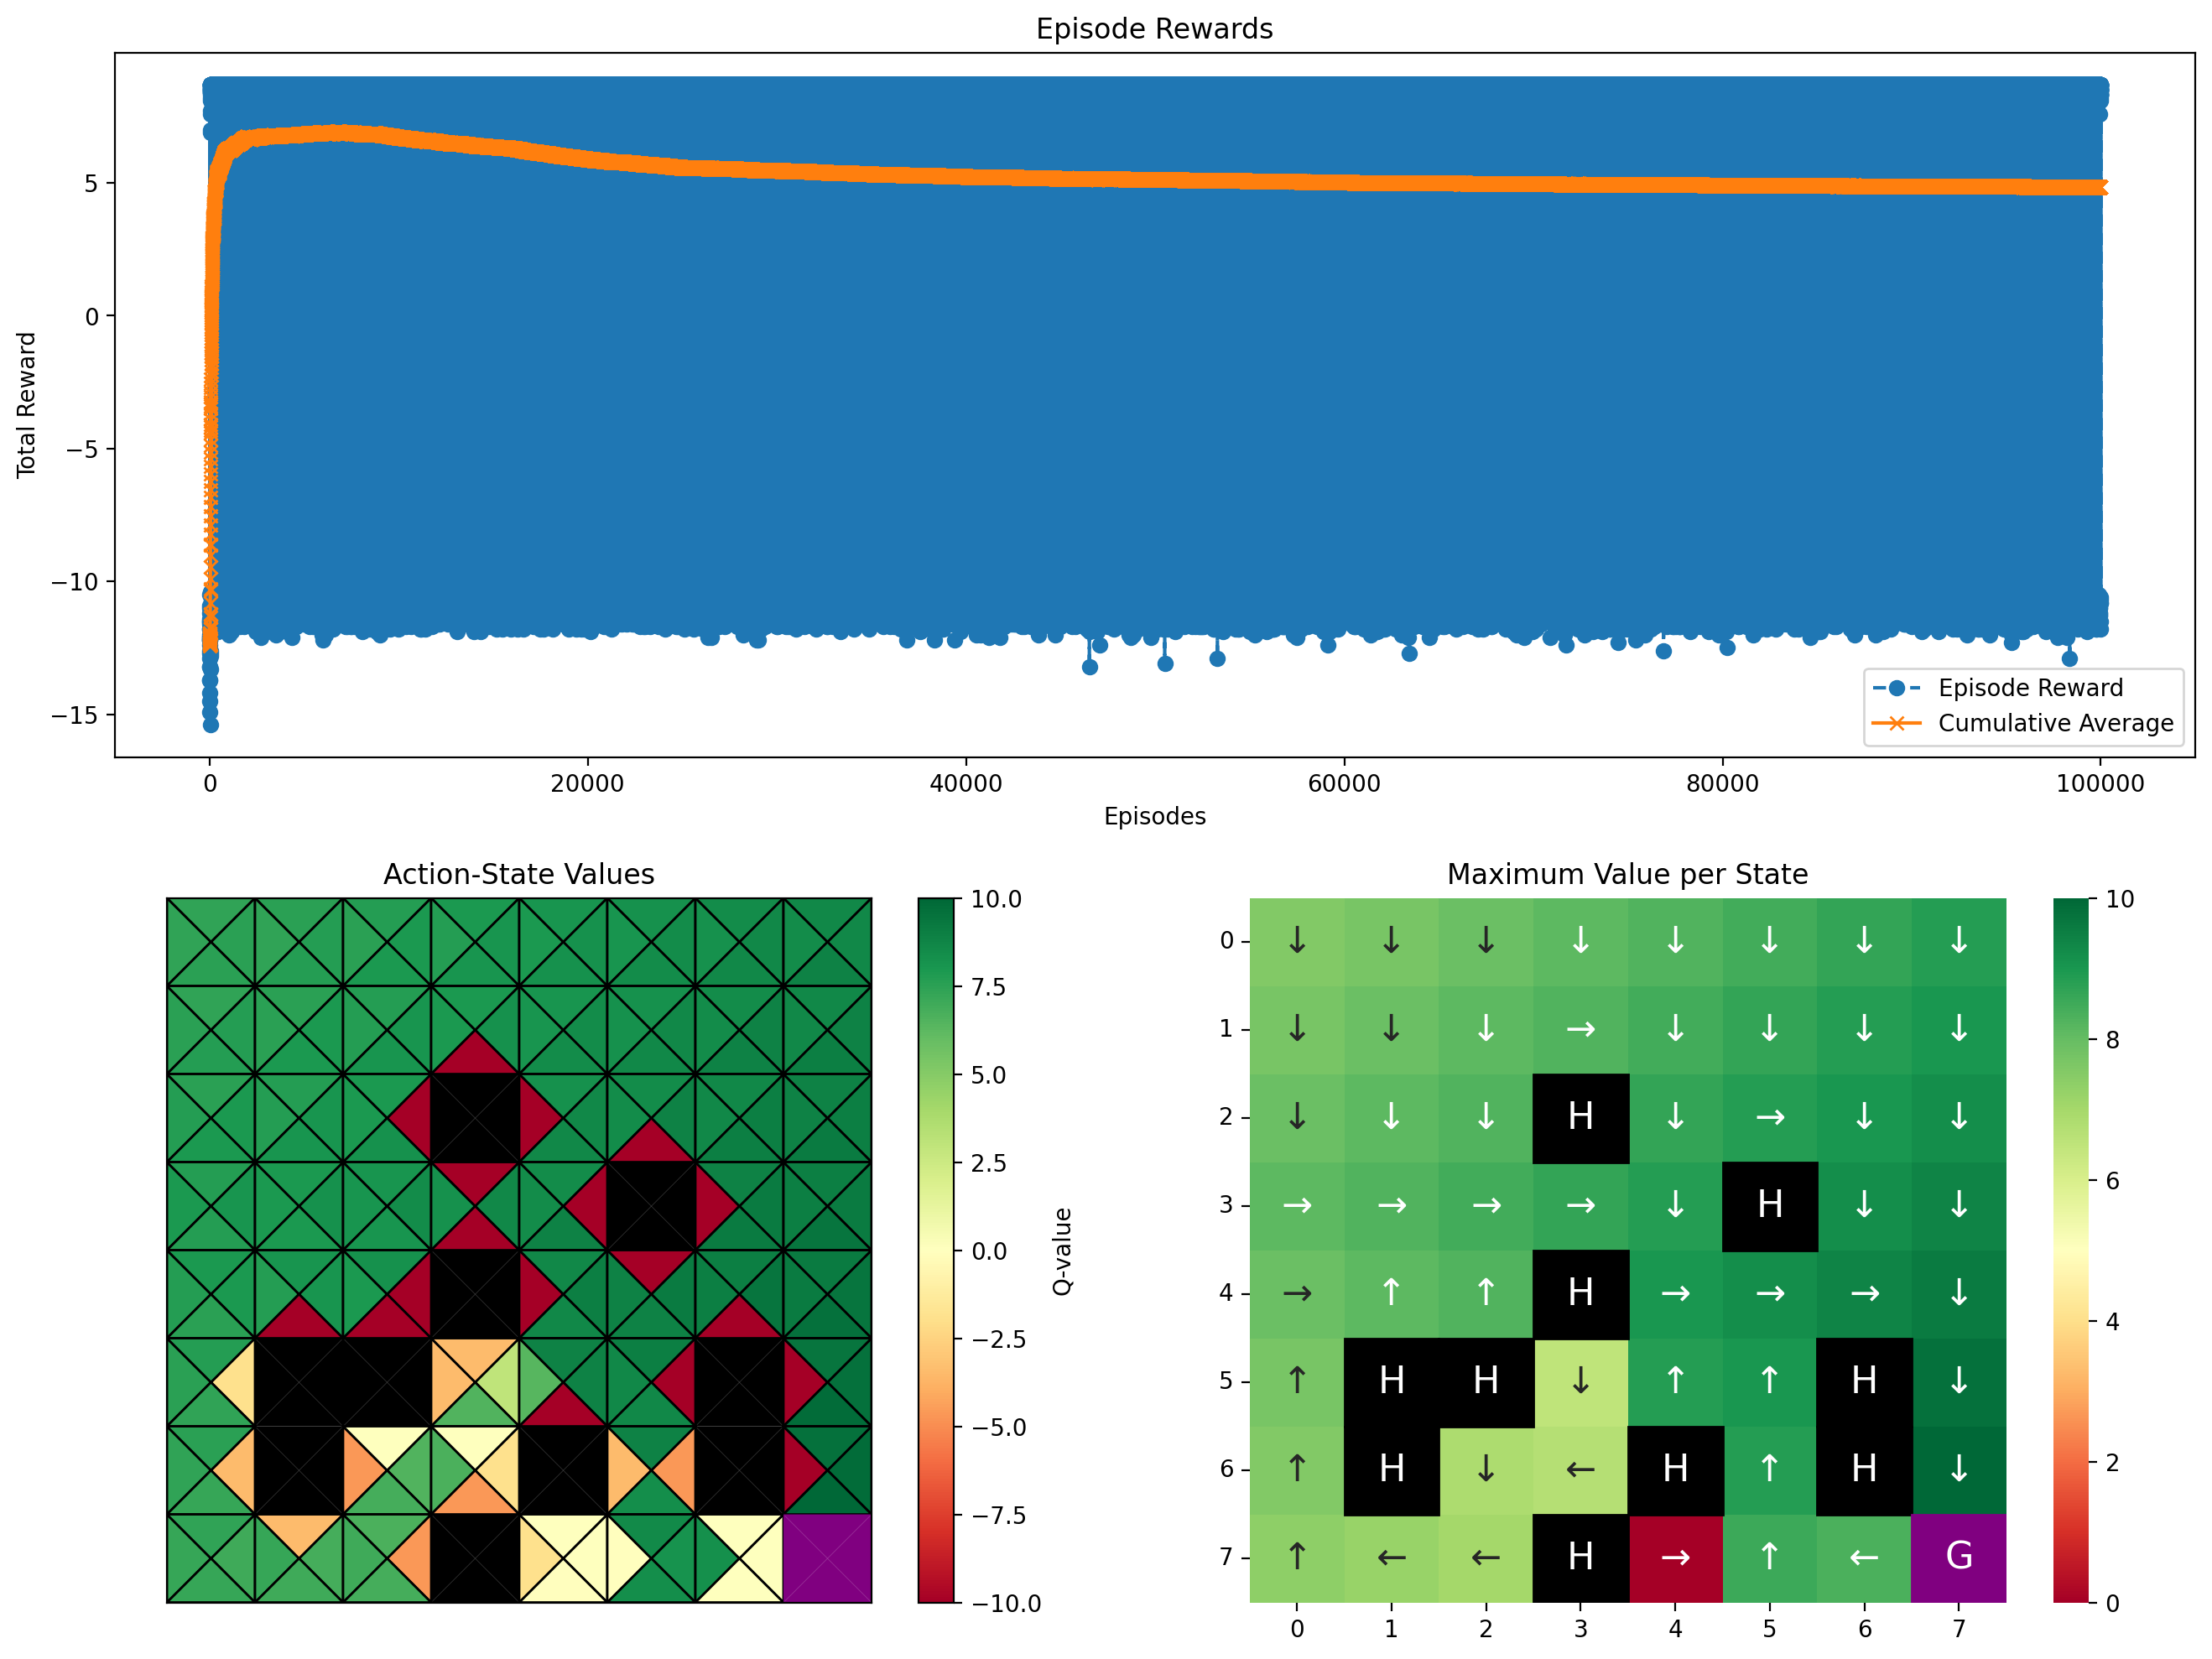

In [20]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'epsilon': 0.1,    # epsilon-greedy policy
          'alpha': 0.1,      # learning rate
          'gamma': 0.99,     # temporal discount factor
          'n': 50,           # number of planning steps
          'theta': 0.1       # prioritization threshold
}

# episodes/trials
n_episodes = 100000

# environment initialization using our custom environment with reward shaping
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=False)

# Solve Frozen Lake using Dyna-Q with Prioritized Sweeping
value_dyna_q, reward_sums_dyna_q = dyna_q_priority(n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)

Visualize the learned policy.

In [21]:
env = CustomFrozenLakeEnv(map_name="8x8", render_mode="rgb_array", is_slippery=False)
create_policy_eval_video(env, greedy_policy, 'DynaQ', Q=value_dyna_q)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Explain how these last improvements helped.

`Your Answer:`

### Explanation of How the Latest Improvements Helped

1. **Focused Learning via Prioritized Sweeping:**  
   Prioritized Sweeping uses a priority queue to focus planning updates on state-action pairs with high TD errors. This means that instead of uniformly sampling past experiences, the algorithm concentrates on transitions that indicate a significant discrepancy between expected and received rewards. As a result, the most “informative” transitions are updated first, which accelerates the propagation of reward signals through the value function.

2. **Efficient Value Propagation:**  
   By updating the Q-values for the state-action pairs that lead to large errors, the agent can more rapidly correct and improve its policy. This focused update strategy is particularly beneficial in sparse-reward environments like FrozenLake, where positive feedback is rare. The improvements propagate quickly to predecessor state-action pairs, leading to more efficient learning overall.

3. **Enhanced Signal through Reward Shaping:**  
   The custom reward function modifies the sparse reward structure of the original environment by:
   - Assigning a high positive reward for reaching the goal,
   - Penalizing falling into holes with a high negative reward, and
   - Providing a small step penalty to encourage quicker task completion.  
   This denser feedback provides a clearer signal for the agent, guiding its exploration and helping it to differentiate between promising and non-promising actions more effectively.

4. **Synergistic Effect:**  
   When combined, prioritized sweeping and reward shaping yield a synergistic effect. While reward shaping ensures that the agent receives more informative and frequent signals, prioritized sweeping ensures that these signals are quickly and efficiently propagated through the Q-values. This results in faster convergence to a better policy, even in environments where rewards are naturally sparse.

In summary, these improvements help the agent focus its updates on the most significant transitions and leverage richer feedback from the environment, leading to more efficient learning and improved performance over time.


# Extra (10 points)

Is in notebook EXTRA